# LLM-Based Pseudo-Factor Analysis (Guenole et al. Methodology)

**Psychometric scale validation using transformer embeddings and exploratory factor analysis**

## Overview

This notebook implements the Pseudo-Factor Analysis (PFA) approach from Guenole et al. for validating psychological scales using pre-trained language model embeddings:

### Key Steps:
1. **Atomic-Reversed Encoding**: Apply item scoring direction (+1/-1) to embeddings
2. **Cosine Similarity Matrix**: Treat normalized similarities as pseudo-correlations
3. **Exploratory Factor Analysis**: ML extraction with oblique rotation
4. **Psychometric Diagnostics**: DAAL, Tucker congruence, KMO/Bartlett tests

### Methodological Choices (Guenole et al.):
- **Extraction**: Maximum Likelihood (ML) - not principal components
- **Rotation**: Oblique (Promax/Oblimin) to allow factor correlations
- **Input**: Cosine similarity of atomic-reversed embeddings
- **Validation**: DAAL, Tucker φ, KMO, Bartlett

### References:
- Guenole, N., et al. (2024). Pre-trained language models for psychometric validation.

---

## Import Dependencies

Import all required libraries for PFA analysis.

In [2]:
import os
import sys
from datetime import datetime
import warnings

# Set HuggingFace cache directory BEFORE importing transformers/sentence_transformers
os.environ['HF_HOME'] = '/home/devon7y/links/scratch/huggingface'
os.environ['TRANSFORMERS_CACHE'] = '/home/devon7y/links/scratch/huggingface'
os.environ['HF_DATASETS_CACHE'] = '/home/devon7y/links/scratch/huggingface'
os.environ['HF_TOKEN'] = 'YOUR_HF_TOKEN_HERE'

import pandas as pd
import numpy as np
import torch

from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from scipy.stats import percentileofscore
import scipy.stats as stats

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

/home/devon7y/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/devon7y/myenv/lib/python3.11/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Configuration

Set all parameters for the analysis.

In [ ]:
# ==============================================================================
# MODEL SELECTION
# ==============================================================================

MODEL_NAMES = [
    "Qwen/Qwen3-Embedding-8B",
]

# ==============================================================================
# PRE-GENERATED WORD EMBEDDINGS
# ==============================================================================
# Specify paths to pre-generated word embeddings for each model size.
# If a path is provided, it will be loaded instead of generating embeddings.
# If empty dict or no key for a model, embeddings will be generated.
# ==============================================================================

PREGENERATED_EMBEDDINGS = {
     "8B": "embeddings/2257_constructs_8B.npz",
    # "4B": "embeddings/word_embeddings_4B.npz",
}

# ==============================================================================
# PRE-GENERATED SCALE EMBEDDINGS
# ==============================================================================
# Specify paths to pre-generated scale item embeddings for each model size.
# If a path is provided, it will be loaded instead of generating embeddings.
# If empty dict or no key for a model, embeddings will be generated from cache or on-the-fly.
# ==============================================================================

PREGENERATED_SCALE_EMBEDDINGS = {
    # "8B": "embeddings/pregenerated_scale_items_8B.npz",
    # "4B": "embeddings/pregenerated_scale_items_4B.npz",
}

# ==============================================================================
# SCALE DATA PATH
# ==============================================================================
# Expected CSV columns:
#   - code: item identifier (e.g., "DASS01", "E1")
#   - item: the text of the scale item
#   - factor: theoretical factor label (e.g., "Anxiety", "Extraversion")
#   - scoring: [OPTIONAL] +1 for normal items, -1 for reverse-scored items
#
# If 'scoring' column is missing, all items default to +1 with a warning.
# ==============================================================================

SCALE_CSV_PATH = 'scales/DASS_items.csv'

# ==============================================================================
# EFA SETTINGS
# ==============================================================================

N_FACTORS = 5  # None = auto via parallel analysis, or set to integer (e.g., 3)

# Rotation method for EFA - 9 methods available:
# 
# OBLIQUE rotations (factors can correlate):
#   - 'promax': Promax rotation (power parameter defaults to 4)
#   - 'oblimin': Direct oblimin rotation (gamma parameter defaults to 0)
#   - 'quartimin': Quartimin rotation (minimizes cross-loadings)
#   - 'geomin_obl': Oblique geomin rotation (delta parameter defaults to 0.01)
#
# ORTHOGONAL rotations (factors remain uncorrelated):
#   - 'varimax': Varimax rotation (maximizes variance of squared loadings)
#   - 'quartimax': Quartimax rotation (minimizes variables' factor complexity)
#   - 'equamax': Equamax rotation (kappa parameter defaults to 0)
#   - 'oblimax': Oblimax rotation
#   - 'geomin_ort': Orthogonal geomin rotation (delta parameter defaults to 0.01)
ROTATION_METHOD = 'oblimin'

# Extraction method for EFA - 5 methods available:
#   - 'minres' or 'uls': Minimum residual / Unweighted Least Squares (fast, stable, default)
#   - 'ml' or 'mle': Maximum Likelihood Extraction (slower, assumes multivariate normality)
#   - 'principal': Principal factor analysis (uses SVD on raw data, requires full dataset)
EXTRACTION_METHOD = 'minres'

EIGEN_CRITERIA = 'parallel'  # 'parallel' (recommended) or 'eigen1'
PARALLEL_ITER = 100
RANDOM_STATE = 42

# ==============================================================================
# ENSEMBLE ANALYSIS
# ==============================================================================

ENSEMBLE = False  # Set to True to average similarity matrices across models

# ==============================================================================
# EMPIRICAL DATA (optional)
# ==============================================================================
# Specify path to raw Likert scale response data (CSV with participants × items).
# Expected format: Wide format with item codes as column headers, participants as rows.
# If provided, traditional factor analysis will be run on the correlation matrix.
# ==============================================================================

EMPIRICAL_DATA_PATH = "scale_responses/DASS_data.csv"  # Set to None to skip empirical analysis

# ==============================================================================
# OUTPUT
# ==============================================================================

SAVE_DIR = 'results'
os.makedirs(SAVE_DIR, exist_ok=True)

# Set random seeds
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# ==============================================================================
# DISPLAY CONFIGURATION
# ==============================================================================

print("Configuration:")
print("="*70)
print(f"Scale: {SCALE_CSV_PATH}")
print(f"Models: {[m.split('/')[-1] for m in MODEL_NAMES]}")
print(f"Factors: {N_FACTORS or 'Auto'}")
print(f"Rotation: {ROTATION_METHOD}")
print(f"Extraction: {EXTRACTION_METHOD}")
print(f"Retention: {EIGEN_CRITERIA}")
print(f"Empirical Data: {EMPIRICAL_DATA_PATH or 'None'}")
print(f"Output: {SAVE_DIR}/")
print("="*70)

## Helper Functions

Functions for atomic-reversed encoding, parallel analysis, DAAL, and Tucker congruence.

In [4]:
def apply_atomic_reversed(embeddings, scoring):
    """Apply atomic-reversed encoding (Guenole et al.)"""
    scoring_array = np.array(scoring).reshape(-1, 1)
    embeddings_signed = embeddings * scoring_array
    norms = np.linalg.norm(embeddings_signed, axis=1)
    zero_norm_items = np.where(norms == 0)[0]
    if len(zero_norm_items) > 0:
        print(f"  WARNING: {len(zero_norm_items)} items have zero norm after signing")
        for idx in zero_norm_items:
            embeddings_signed[idx] = embeddings[idx]
    embeddings_normalized = embeddings_signed / np.linalg.norm(embeddings_signed, axis=1, keepdims=True)
    return embeddings_normalized

def compute_parallel_analysis(corr_matrix, n_iter=100, percentile=95, random_state=42):
    """Parallel analysis for factor retention"""
    np.random.seed(random_state)
    n_items = corr_matrix.shape[0]
    obs_eigenvalues = np.linalg.eigvalsh(corr_matrix)
    obs_eigenvalues = np.sort(obs_eigenvalues)[::-1]
    random_eigenvalues = []
    for _ in range(n_iter):
        random_data = np.random.randn(n_items, n_items)
        random_corr = np.corrcoef(random_data)
        eigs = np.linalg.eigvalsh(random_corr)
        eigs = np.sort(eigs)[::-1]
        random_eigenvalues.append(eigs)
    random_eigenvalues = np.array(random_eigenvalues)
    percentiles = np.percentile(random_eigenvalues, percentile, axis=0)
    n_factors = np.sum(obs_eigenvalues > percentiles)
    return n_factors, obs_eigenvalues, percentiles

def compute_daal(loadings_df, theoretical_factors):
    """Compute DAAL (Dominant Average Absolute Loading)"""
    theoretical_unique = sorted(set(theoretical_factors))
    extracted_factors = loadings_df.columns
    daal_matrix = []
    for ext_factor in extracted_factors:
        row = []
        for theo_factor in theoretical_unique:
            mask = [f == theo_factor for f in theoretical_factors]
            loadings_subset = loadings_df.loc[mask, ext_factor]
            daal_value = loadings_subset.abs().mean()
            row.append(daal_value)
        daal_matrix.append(row)
    daal_df = pd.DataFrame(daal_matrix, index=extracted_factors, columns=theoretical_unique)
    return daal_df

def compute_tucker_congruence(factor_loadings, reference_loadings):
    """Compute Tucker congruence coefficient (phi)"""
    numerator = np.sum(factor_loadings * reference_loadings)
    denom = np.sqrt(np.sum(factor_loadings**2)) * np.sqrt(np.sum(reference_loadings**2))
    return numerator / denom if denom != 0 else 0.0

def create_theoretical_indicators(theoretical_factors, codes):
    """Create indicator matrix for theoretical factors"""
    unique_factors = sorted(set(theoretical_factors))
    indicators = []
    for factor in unique_factors:
        indicator = [1.0 if f == factor else 0.0 for f in theoretical_factors]
        indicators.append(indicator)
    indicators_df = pd.DataFrame(np.array(indicators).T, columns=unique_factors, index=codes)
    return indicators_df

print("✓ Helper functions defined")

✓ Helper functions defined


## Load and Validate Data

Load scale items from CSV and validate required columns.

In [5]:
print(f"Loading {SCALE_CSV_PATH}...")
scale = pd.read_csv(SCALE_CSV_PATH)
print(f"Loaded {len(scale)} items")

# Validate columns
required = ['code', 'item', 'factor']
missing = [c for c in required if c not in scale.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

print("✓ Required columns present")

# Handle scoring column
if 'scoring' in scale.columns:
    print("✓ 'scoring' column found")
else:
    print("⚠ WARNING: 'scoring' column missing - defaulting to +1")
    scale['scoring'] = 1

print(f"\nScoring: {(scale['scoring']==1).sum()} normal, {(scale['scoring']==-1).sum()} reverse")
print(f"Factors: {scale['factor'].nunique()} unique")
print(scale['factor'].value_counts().sort_index())

# Extract data
codes = scale['code'].tolist()
items = scale['item'].tolist()
factors = scale['factor'].tolist()
scoring = scale['scoring'].tolist()

print(f"\n✓ Data validated: {len(items)} items, {len(set(factors))} factors")

Loading scales/DASS_items.csv...
Loaded 42 items
✓ Required columns present
⚠ WARNING: 'scoring' column missing - defaulting to +1

Scoring: 42 normal, 0 reverse
Factors: 3 unique
factor
Anxiety       14
Depression    14
Stress        14
Name: count, dtype: int64

✓ Data validated: 42 items, 3 factors


In [ ]:
# ==============================================================================
# Load Empirical Response Data (Optional)
# ==============================================================================

empirical_data = None

if EMPIRICAL_DATA_PATH is not None:
    print(f"\n{'='*70}")
    print("Loading empirical response data...")
    print(f"{'='*70}")
    
    try:
        # Load tab-separated CSV (participants × items)
        empirical_df = pd.read_csv(EMPIRICAL_DATA_PATH, sep='\t')
        
        print(f"✓ Loaded from: {EMPIRICAL_DATA_PATH}")
        print(f"  Shape: {empirical_df.shape} (participants × items)")
        print(f"  Participants: {len(empirical_df):,}")
        print(f"  Items: {len(empirical_df.columns)}")
        
        # Validate column names match item codes
        data_codes = list(empirical_df.columns)
        if data_codes != codes:
            print(f"\n⚠ WARNING: Column mismatch detected!")
            print(f"  Scale definition codes: {codes[:5]}...")
            print(f"  Data columns: {data_codes[:5]}...")
            
            # Check if columns can be reordered
            if set(data_codes) == set(codes):
                print(f"  → Reordering columns to match scale definition...")
                empirical_df = empirical_df[codes]
                print(f"  ✓ Columns reordered successfully")
            else:
                missing = set(codes) - set(data_codes)
                extra = set(data_codes) - set(codes)
                print(f"  → Missing codes: {missing}")
                print(f"  → Extra codes: {extra}")
                raise ValueError("Column names do not match scale item codes")
        else:
            print(f"  ✓ Column names match scale item codes")
        
        # Convert to numpy array for analysis
        empirical_data = empirical_df.values.astype(float)
        
        # Transform from 1-4 scale to 0-3 (standard DASS scoring)
        # Check if data appears to be 1-4 or already 0-3
        min_val = empirical_data.min()
        max_val = empirical_data.max()
        
        print(f"\n  Response range: [{min_val:.0f}, {max_val:.0f}]")
        
        if min_val >= 1 and max_val <= 4:
            print(f"  → Detected 1-4 scale, converting to 0-3 (standard DASS)...")
            empirical_data = empirical_data - 1
            print(f"  ✓ Converted to range [0, 3]")
        elif min_val >= 0 and max_val <= 3:
            print(f"  → Already in 0-3 range (standard DASS)")
        else:
            print(f"  ⚠ WARNING: Unexpected response range")
        
        # Display sample statistics
        print(f"\n  Sample statistics:")
        print(f"    Mean response: {empirical_data.mean():.2f}")
        print(f"    SD response: {empirical_data.std():.2f}")
        print(f"    Missing values: {np.isnan(empirical_data).sum():,}")
        
        # Show first few responses for first 5 items
        print(f"\n  First 3 participants × first 5 items:")
        for i in range(min(3, len(empirical_data))):
            row_str = "  " + ", ".join([f"{val:.0f}" for val in empirical_data[i, :5]])
            print(f"    Participant {i+1}: [{row_str}]")
        
        print(f"\n✓ Empirical data ready for analysis")
        
    except FileNotFoundError:
        print(f"\n✗ ERROR: File not found: {EMPIRICAL_DATA_PATH}")
        print("  Empirical analysis will be skipped.")
        empirical_data = None
    except Exception as e:
        print(f"\n✗ ERROR loading empirical data:")
        print(f"  {type(e).__name__}: {str(e)}")
        print("  Empirical analysis will be skipped.")
        empirical_data = None
else:
    print(f"\n{'='*70}")
    print("Empirical data path not specified - skipping empirical analysis")
    print(f"{'='*70}")

## Device Detection

In [6]:
if torch.cuda.is_available():
    device = 'cuda'
    print(f"✓ CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = 'mps'
    print("✓ Apple MPS")
else:
    device = 'cpu'
    print("Using CPU")

print(f"Device: {device}")

✓ CUDA: NVIDIA H100 80GB HBM3
Device: cuda


## Load or Generate Embeddings

In [ ]:
import glob

all_embeddings = {}
model_sizes = []

for model_name in MODEL_NAMES:
    model_size = model_name.split('-')[-1]
    model_sizes.append(model_size)
    
    print(f"\nModel: {model_name} ({model_size})")
    
    # Check if pregenerated embeddings are specified for this model
    if model_size in PREGENERATED_SCALE_EMBEDDINGS:
        scale_emb_path = PREGENERATED_SCALE_EMBEDDINGS[model_size]
        if os.path.exists(scale_emb_path):
            print(f"  Loading pregenerated from {scale_emb_path}...")
            try:
                data = np.load(scale_emb_path, allow_pickle=True)
                
                # Try different possible key names for embeddings
                embeddings = None
                for key in ['embeddings', 'scale_embeddings', 'vectors', 'arr_0']:
                    if key in data:
                        embeddings = data[key]
                        print(f"  ✓ Loaded from key '{key}': {embeddings.shape}")
                        break
                
                if embeddings is None:
                    print(f"  ⚠ Warning: No valid embedding key found in {scale_emb_path}")
                    print(f"    Available keys: {list(data.keys())}")
                    print(f"    Falling back to cache or generation...")
                else:
                    # Verify shape matches item count
                    if embeddings.shape[0] != len(items):
                        print(f"  ⚠ WARNING: Embedding count ({embeddings.shape[0]}) != item count ({len(items)})")
                        print(f"    Falling back to cache or generation...")
                    else:
                        all_embeddings[model_size] = embeddings
                        continue
                        
            except Exception as e:
                print(f"  ⚠ Warning: Error loading pregenerated embeddings:")
                print(f"    {type(e).__name__}: {str(e)}")
                print(f"    Falling back to cache or generation...")
        else:
            print(f"  ⚠ Pregenerated path specified but file not found: {scale_emb_path}")
            print(f"    Falling back to cache or generation...")
    
    # Check if embeddings already cached
    save_path = f"embeddings/scale_items_{model_size}.npz"
    
    if os.path.exists(save_path):
        print(f"  Loading from cache: {save_path}...")
        data = np.load(save_path, allow_pickle=True)
        embeddings = data['embeddings']
        print(f"  ✓ Loaded: {embeddings.shape}")
        all_embeddings[model_size] = embeddings
        continue
    
    # Generate embeddings
    print(f"  Generating embeddings...")
    
    # Find the snapshot path
    model_cache_name = model_name.replace('/', '--')
    snapshots_dir = f"/home/devon7y/links/scratch/huggingface/models--{model_cache_name}/snapshots"
    
    # Get the most recent snapshot (should only be one)
    snapshot_dirs = glob.glob(f"{snapshots_dir}/*")
    if not snapshot_dirs:
        raise FileNotFoundError(f"No snapshots found in {snapshots_dir}")
    
    snapshot_path = snapshot_dirs[0]
    print(f"  Loading from: {snapshot_path}")
    
    # Load model without local_files_only since we're using direct path
    model = SentenceTransformer(snapshot_path, device=device)
    
    embeddings = model.encode(items, show_progress_bar=True, batch_size=21, 
                              convert_to_numpy=True, normalize_embeddings=False)
    print(f"  ✓ Generated: {embeddings.shape}")
    all_embeddings[model_size] = embeddings
    
    # Save to cache
    os.makedirs("embeddings", exist_ok=True)
    np.savez(save_path, embeddings=embeddings, codes=codes, items=items)
    print(f"  ✓ Saved to {save_path}")

print(f"\n✓ All embeddings ready: {list(all_embeddings.keys())}")

## Main PFA Pipeline Function

The core function that runs all 7 steps of the Pseudo-Factor Analysis pipeline.

In [ ]:
def run_pfa_for_model(model_size, embeddings, codes, items, factors, scoring,
                       n_factors=None, rotation='promax', extraction_method='minres',
                       eigen_criteria='parallel', parallel_iter=100, random_state=42,
                       save_dir='results'):
    """
    Run complete Pseudo-Factor Analysis pipeline for one model.

    Args:
        model_size: str, e.g., "4B"
        embeddings: (n_items, dim) array
        codes: list of item codes
        items: list of item texts
        factors: list of theoretical factor labels
        scoring: list of +1/-1 scoring directions
        n_factors: int or None (None = auto via parallel analysis)
        rotation: str, rotation method (e.g., 'promax', 'oblimin', 'varimax')
        extraction_method: str, extraction method (e.g., 'minres', 'ml', 'principal')
        eigen_criteria: 'parallel' or 'eigen1'
        parallel_iter: int, iterations for parallel analysis
        random_state: int, for reproducibility
        save_dir: directory to save results

    Returns:
        results: dict with all results
    """

    print(f"PSEUDO-FACTOR ANALYSIS: {model_size}")

    results = {'model_size': model_size}

    # Step 1: Atomic-reversed encoding
    print("\n[1/7] Applying atomic-reversed encoding...")
    embeddings_ar = apply_atomic_reversed(embeddings, scoring)
    print(f"  ✓ Shape: {embeddings_ar.shape}")

    # Step 2: Cosine similarity matrix
    print("\n[2/7] Computing cosine similarity matrix...")
    sim_matrix = cosine_similarity(embeddings_ar)
    print(f"  ✓ Shape: {sim_matrix.shape}")

    results['similarity_matrix'] = sim_matrix

    # Step 3: Sampling adequacy tests
    print("\n[3/7] Computing KMO and Bartlett test...")
    
    FACTOR_ANALYZER_AVAILABLE = True
    if FACTOR_ANALYZER_AVAILABLE:
        kmo_per_item, kmo_total = calculate_kmo(sim_matrix)
        print(f"  ✓ KMO overall: {kmo_total:.3f}")

        if kmo_total < 0.5:
            print("    ⚠ WARNING: KMO < 0.5 (unacceptable)")
        elif kmo_total < 0.6:
            print("    ⚠ WARNING: KMO < 0.6 (poor)")
        elif kmo_total < 0.7:
            print("    KMO is mediocre")
        elif kmo_total < 0.8:
            print("    KMO is middling")
        elif kmo_total < 0.9:
            print("    KMO is meritorious")
        else:
            print("    KMO is marvelous")

        chi_square, p_value = calculate_bartlett_sphericity(sim_matrix)
        print(f"  ✓ Bartlett: χ²={chi_square:.2f}, p={p_value:.4e}")

        if p_value > 0.05:
            print("    ⚠ WARNING: Not significant (p > 0.05)")
        else:
            print("    ✓ Significant (p < 0.05)")

        results['kmo_total'] = kmo_total
        results['kmo_per_item'] = kmo_per_item
        results['bartlett_chi2'] = chi_square
        results['bartlett_p'] = p_value
    else:
        print("  ⚠ Skipping (factor_analyzer not available)")

    # Step 4: Parallel analysis for factor retention
    print("\n[4/7] Determining number of factors...")

    if n_factors is None:
        if eigen_criteria == 'parallel':
            print(f"  Running parallel analysis ({parallel_iter} iterations)...")
            n_factors_auto, obs_eigs, percentile_eigs = compute_parallel_analysis(
                sim_matrix, n_iter=parallel_iter, random_state=random_state
            )
            print(f"  ✓ Suggested {n_factors_auto} factors")
            n_factors = max(1, n_factors_auto)
            results['observed_eigenvalues'] = obs_eigs
            results['percentile_eigenvalues'] = percentile_eigs
        else:  # eigen1
            eigs = np.linalg.eigvalsh(sim_matrix)
            eigs = np.sort(eigs)[::-1]
            n_factors = np.sum(eigs > 1)
            print(f"  ✓ Kaiser rule (eigen>1): {n_factors} factors")
            results['observed_eigenvalues'] = eigs

    print(f"  ✓ Extracting {n_factors} factors with {rotation} rotation")
    results['n_factors'] = n_factors

    # Step 5: Exploratory Factor Analysis
    print("\n[5/7] Running Exploratory Factor Analysis...")

    fa = FactorAnalyzer(
        n_factors=n_factors,
        rotation=rotation,
        method=extraction_method,
        rotation_kwargs={'normalize': True} if rotation in ['promax', 'oblimin'] else {}
    )

    fa.fit(sim_matrix)
    print("  ✓ EFA complete")

    loadings = fa.loadings_
    communalities = fa.get_communalities()
    uniquenesses = fa.get_uniquenesses()
    variance = fa.get_factor_variance()

    factor_names = [f"Factor{i+1}" for i in range(n_factors)]
    loadings_df = pd.DataFrame(loadings, index=codes, columns=factor_names)

    print(f"  Loadings shape: {loadings.shape}")
    print(f"  Variance explained (cumulative): {variance[2][-1]:.1%}")

    variance_df = pd.DataFrame(variance, index=['SS Loadings', 'Proportion', 'Cumulative'])

    communalities_df = pd.DataFrame({
        'communality': communalities,
        'uniqueness': uniquenesses
    }, index=codes)

    results['loadings'] = loadings_df
    results['variance'] = variance
    results['communalities'] = communalities
    results['uniquenesses'] = uniquenesses

    # Step 6: DAAL diagnostic
    print("\n[6/7] Computing DAAL...")

    daal_df = compute_daal(loadings_df, factors)
    print(f"  ✓ DAAL matrix: {daal_df.shape}")

    assignments = []
    for ext_factor in daal_df.index:
        best_theo = daal_df.loc[ext_factor].idxmax()
        best_daal = daal_df.loc[ext_factor, best_theo]
        assignments.append({
            'extracted': ext_factor,
            'assigned_to': best_theo,
            'daal': best_daal
        })

    assignments_df = pd.DataFrame(assignments)
    print("\n  Factor assignments (DAAL):")
    for _, row in assignments_df.iterrows():
        print(f"    {row['extracted']} → {row['assigned_to']} (DAAL={row['daal']:.3f})")

    results['daal'] = daal_df
    results['daal_assignments'] = assignments_df

    # Step 7: Tucker congruence
    print("\n[7/7] Computing Tucker congruence...")

    theoretical_indicators = create_theoretical_indicators(factors, codes)

    tucker_matrix = []
    for ext_factor in factor_names:
        row = []
        for theo_factor in theoretical_indicators.columns:
            phi = compute_tucker_congruence(
                loadings_df[ext_factor].values,
                theoretical_indicators[theo_factor].values
            )
            row.append(phi)
        tucker_matrix.append(row)

    tucker_df = pd.DataFrame(
        tucker_matrix,
        index=factor_names,
        columns=theoretical_indicators.columns
    )

    print(f"  ✓ Tucker matrix: {tucker_df.shape}")
    print("\n  Interpretation guide:")
    print("    φ ≥ .95: Excellent agreement")
    print("    φ ≥ .85: Fair agreement")
    print("    φ < .85: Poor agreement")

    tucker_best = []
    for ext_factor in tucker_df.index:
        best_theo = tucker_df.loc[ext_factor].idxmax()
        best_phi = tucker_df.loc[ext_factor, best_theo]
        tucker_best.append({
            'extracted': ext_factor,
            'best_match': best_theo,
            'tucker_phi': best_phi
        })

    tucker_best_df = pd.DataFrame(tucker_best)
    print("\n  Best matches (Tucker φ):")
    for _, row in tucker_best_df.iterrows():
        print(f"    {row['extracted']} ↔ {row['best_match']} (φ={row['tucker_phi']:.3f})")

    results['tucker'] = tucker_df
    results['tucker_best'] = tucker_best_df

    # Combined diagnostics
    diagnostics = {
        'model': model_size,
        'n_items': len(codes),
        'n_factors_extracted': n_factors,
        'rotation': rotation,
    }

    if FACTOR_ANALYZER_AVAILABLE:
        diagnostics['kmo'] = kmo_total
        diagnostics['bartlett_p'] = p_value

    diagnostics['variance_explained'] = variance[2][-1]

    diagnostics_df = pd.DataFrame([diagnostics])

    results['diagnostics'] = diagnostics_df

    print(f"\n{'='*70}")
    print(f"✓ PFA COMPLETE FOR {model_size}")
    print('='*70)

    return results

In [ ]:
def run_efa_on_data(data_label, response_data, codes, items, factors, scoring,
                    n_factors=None, rotation='promax', extraction_method='minres',
                    eigen_criteria='parallel', parallel_iter=100, random_state=42,
                    save_dir='results'):
    """
    Run traditional Exploratory Factor Analysis on raw Likert scale response data.
    
    This function follows traditional factor analysis conventions:
    - Uses Pearson correlation matrix instead of cosine similarity
    - Applies reverse scoring but does NOT normalize to unit vectors
    - Otherwise identical pipeline to run_pfa_for_model()
    
    Parameters:
    -----------
    data_label : str
        Label for this dataset (e.g., "Empirical", "DASS_Study1")
    response_data : ndarray of shape (n_participants, n_items)
        Raw Likert scale responses (participants × items)
    codes : list of str
        Item codes (e.g., ["S1", "A2", "D3"])
    items : list of str
        Full item text
    factors : list of str
        Theoretical factor labels
    scoring : list of int
        +1 for normal items, -1 for reverse-scored
    n_factors : int or None
        Number of factors to extract (None = auto via parallel analysis)
    rotation : str
        Rotation method ('promax', 'oblimin', 'varimax', etc.)
    extraction_method : str
        'minres', 'ml', or 'principal'
    eigen_criteria : str
        'parallel' or 'eigen1'
    parallel_iter : int
        Iterations for parallel analysis
    random_state : int
        Random seed for reproducibility
    save_dir : str
        Output directory
        
    Returns:
    --------
    dict : Analysis results including correlation matrix, loadings, diagnostics, etc.
    """
    
    print(f"\n{'='*70}")
    print(f"TRADITIONAL EFA - {data_label}")
    print(f"{'='*70}")
    print(f"Data: {response_data.shape[0]:,} participants × {response_data.shape[1]} items")
    print(f"Rotation: {rotation}")
    print(f"Extraction: {extraction_method}")
    
    # =========================================================================
    # Step 1: Apply Reverse Scoring (Traditional FA Convention)
    # =========================================================================
    print(f"\n[1/7] Applying reverse scoring...")
    
    # Apply scoring direction to each item (column-wise)
    # Unlike embeddings, we do NOT normalize - keep raw scale values
    response_scored = response_data.copy()
    for i, score_dir in enumerate(scoring):
        if score_dir == -1:
            # Reverse score: for 0-3 scale, reverse is (3 - x)
            max_val = response_data[:, i].max()
            response_scored[:, i] = max_val - response_data[:, i]
    
    reverse_count = sum(1 for s in scoring if s == -1)
    print(f"  ✓ Applied reverse scoring to {reverse_count}/{len(scoring)} items")
    print(f"  ✓ Data shape: {response_scored.shape}")
    
    # =========================================================================
    # Step 2: Compute Correlation Matrix (Traditional FA Convention)
    # =========================================================================
    print(f"\n[2/7] Computing correlation matrix...")
    
    # Compute Pearson correlation between items (columns)
    # np.corrcoef expects variables as rows, so transpose
    corr_matrix = np.corrcoef(response_scored.T)
    
    print(f"  ✓ Correlation matrix shape: {corr_matrix.shape}")
    print(f"  ✓ Correlation range: [{corr_matrix.min():.3f}, {corr_matrix.max():.3f}]")
    print(f"  ✓ Mean correlation: {corr_matrix[np.triu_indices_from(corr_matrix, k=1)].mean():.3f}")
    
    # =========================================================================
    # Step 3: Sampling Adequacy Tests
    # =========================================================================
    print(f"\n[3/7] Testing sampling adequacy...")
    
    from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
    
    kmo_per_item, kmo_total = calculate_kmo(corr_matrix)
    bartlett_chi2, bartlett_p = calculate_bartlett_sphericity(corr_matrix)
    
    print(f"  KMO Measure of Sampling Adequacy: {kmo_total:.3f}")
    if kmo_total >= 0.9:
        print(f"    → Excellent (≥0.9)")
    elif kmo_total >= 0.8:
        print(f"    → Good (≥0.8)")
    elif kmo_total >= 0.7:
        print(f"    → Adequate (≥0.7)")
    elif kmo_total >= 0.6:
        print(f"    → Mediocre (≥0.6)")
    else:
        print(f"    → Poor (<0.6)")
    
    print(f"  Bartlett's Test of Sphericity:")
    print(f"    χ²({len(codes)*(len(codes)-1)//2}) = {bartlett_chi2:.2f}, p = {bartlett_p:.2e}")
    if bartlett_p < 0.001:
        print(f"    → Correlations are factorable (p < .001)")
    else:
        print(f"    → ⚠ Warning: p ≥ .001")
    
    # =========================================================================
    # Step 4: Determine Number of Factors
    # =========================================================================
    print(f"\n[4/7] Determining number of factors...")
    
    if n_factors is None:
        if eigen_criteria == 'parallel':
            n_factors_auto, obs_eigs, pct_eigs = compute_parallel_analysis(
                corr_matrix, n_iter=parallel_iter, percentile=95, random_state=random_state
            )
            print(f"  Parallel Analysis (95th percentile, {parallel_iter} iterations):")
            print(f"    → Suggested factors: {n_factors_auto}")
            n_factors = n_factors_auto
        elif eigen_criteria == 'eigen1':
            eigenvalues = np.linalg.eigvalsh(corr_matrix)[::-1]
            n_factors_auto = np.sum(eigenvalues > 1.0)
            obs_eigs = eigenvalues
            pct_eigs = None
            print(f"  Kaiser Criterion (eigenvalue > 1):")
            print(f"    → Suggested factors: {n_factors_auto}")
            n_factors = n_factors_auto
        else:
            raise ValueError(f"Unknown eigen_criteria: {eigen_criteria}")
    else:
        print(f"  Using specified n_factors: {n_factors}")
        obs_eigs = np.linalg.eigvalsh(corr_matrix)[::-1]
        pct_eigs = None
    
    # =========================================================================
    # Step 5: Run EFA
    # =========================================================================
    print(f"\n[5/7] Running EFA extraction...")
    print(f"  Extracting {n_factors} factors with {rotation} rotation...")
    
    from factor_analyzer import FactorAnalyzer
    
    fa = FactorAnalyzer(n_factors=n_factors, rotation=rotation, method=extraction_method)
    fa.fit(corr_matrix)
    
    loadings_array = fa.loadings_
    variance_array = fa.get_factor_variance()
    
    # Create loadings DataFrame
    factor_names = [f"Factor{i+1}" for i in range(n_factors)]
    loadings_df = pd.DataFrame(loadings_array, index=codes, columns=factor_names)
    
    print(f"  ✓ Extraction complete")
    print(f"  ✓ Loadings shape: {loadings_df.shape}")
    print(f"  ✓ Total variance explained: {variance_array[2][-1]:.1%}")
    
    # Save variance
    variance_df = pd.DataFrame(
        variance_array,
        index=['SS Loadings', 'Proportion Var', 'Cumulative Var'],
        columns=factor_names
    )
    
    # Save communalities
    communalities = fa.get_communalities()
    comm_df = pd.DataFrame({'code': codes, 'communality': communalities})
    
    # =========================================================================
    # Step 6: DAAL (Dominant Average Absolute Loading)
    # =========================================================================
    print(f"\n[6/7] Computing DAAL...")
    
    daal_df = compute_daal(loadings_df, factors)
    
    # Find best matches
    daal_assignments = []
    for ext_factor in factor_names:
        theo_factor = daal_df.loc[ext_factor].idxmax()
        daal_value = daal_df.loc[ext_factor, theo_factor]
        daal_assignments.append({
            'extracted_factor': ext_factor,
            'assigned_to': theo_factor,
            'daal': daal_value
        })
    daal_assignments_df = pd.DataFrame(daal_assignments)
    
    print(f"  Factor assignments (by DAAL):")
    for _, row in daal_assignments_df.iterrows():
        print(f"    {row['extracted_factor']} → {row['assigned_to']} (DAAL = {row['daal']:.3f})")
    
    # =========================================================================
    # Step 7: Tucker Congruence
    # =========================================================================
    print(f"\n[7/7] Computing Tucker congruence...")
    
    theoretical_indicators = create_theoretical_indicators(factors, codes)
    
    tucker_matrix = []
    for ext_factor in factor_names:
        row = []
        for theo_factor in theoretical_indicators.columns:
            phi = compute_tucker_congruence(
                loadings_df[ext_factor].values,
                theoretical_indicators[theo_factor].values
            )
            row.append(phi)
        tucker_matrix.append(row)
    
    tucker_df = pd.DataFrame(
        tucker_matrix,
        index=factor_names,
        columns=theoretical_indicators.columns
    )
    
    # Find best matches
    tucker_best = []
    for ext_factor in factor_names:
        theo_factor = tucker_df.loc[ext_factor].idxmax()
        phi_value = tucker_df.loc[ext_factor, theo_factor]
        
        if phi_value >= 0.95:
            quality = "Excellent"
        elif phi_value >= 0.85:
            quality = "Fair"
        else:
            quality = "Poor"
        
        tucker_best.append({
            'extracted_factor': ext_factor,
            'best_match': theo_factor,
            'tucker_phi': phi_value,
            'quality': quality
        })
    tucker_best_df = pd.DataFrame(tucker_best)
    
    print(f"  Best matches (by Tucker φ):")
    for _, row in tucker_best_df.iterrows():
        print(f"    {row['extracted_factor']} → {row['best_match']} (φ = {row['tucker_phi']:.3f}, {row['quality']})")
    
    # =========================================================================
    # Create diagnostics summary
    # =========================================================================
    diagnostics_df = pd.DataFrame({
        'metric': ['KMO', 'Bartlett χ²', 'Bartlett p', 'n_factors', 'variance_explained'],
        'value': [kmo_total, bartlett_chi2, bartlett_p, n_factors, variance_array[2][-1]]
    })
    
    print(f"\n{'='*70}")
    print(f"✓ EFA COMPLETE - {data_label}")
    print(f"{'='*70}")
    
    # Return results dictionary
    return {
        'data_label': data_label,
        'similarity_matrix': corr_matrix,  # Using same key name for compatibility
        'kmo_total': kmo_total,
        'kmo_per_item': kmo_per_item,
        'bartlett_chi2': bartlett_chi2,
        'bartlett_p': bartlett_p,
        'n_factors': n_factors,
        'observed_eigenvalues': obs_eigs,
        'percentile_eigenvalues': pct_eigs,
        'loadings': loadings_df,
        'variance': variance_array,
        'communalities': communalities,
        'uniquenesses': fa.get_uniquenesses(),
        'daal': daal_df,
        'daal_assignments': daal_assignments_df,
        'tucker': tucker_df,
        'tucker_best': tucker_best_df,
        'diagnostics': diagnostics_df
    }

## Visualization Function

Create comprehensive visualizations of PFA results.

In [ ]:
def create_visualizations(results, factors, codes, model_size, save_dir='results', data_type='embeddings'):
    """
    Create all visualizations for PFA/EFA results
    
    Parameters:
    -----------
    results : dict
        Results dictionary from run_pfa_for_model() or run_efa_on_data()
    factors : list
        Theoretical factor labels
    codes : list
        Item codes
    model_size : str
        Model identifier or data label
    save_dir : str
        Output directory
    data_type : str
        'embeddings' for cosine similarity, 'empirical' for correlation
    """

    print(f"\nCreating visualizations for {model_size}...")

    fig = plt.figure(figsize=(20, 12))

    # 1. Scree plot
    ax1 = plt.subplot(2, 3, 1)
    if 'observed_eigenvalues' in results:
        obs_eigs = results['observed_eigenvalues']
        n_show = min(20, len(obs_eigs))
        ax1.plot(range(1, n_show + 1), obs_eigs[:n_show], 'o-', label='Observed', linewidth=2)

        if 'percentile_eigenvalues' in results and results['percentile_eigenvalues'] is not None:
            perc_eigs = results['percentile_eigenvalues']
            ax1.plot(range(1, n_show + 1), perc_eigs[:n_show], 's--',
                    label='95th percentile (random)', linewidth=2)

        ax1.axhline(1, color='red', linestyle='--', alpha=0.5, label='Eigen = 1')
        ax1.set_xlabel('Factor Number')
        ax1.set_ylabel('Eigenvalue')
        ax1.set_title(f'Scree Plot - {model_size}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

    # 2. Similarity/Correlation matrix heatmap
    ax2 = plt.subplot(2, 3, 2)
    if 'similarity_matrix' in results:
        sim = results['similarity_matrix']
        factor_order = sorted(range(len(factors)), key=lambda i: (factors[i], i))
        sim_ordered = sim[factor_order][:, factor_order]

        # Use appropriate label based on data type
        cbar_label = 'Correlation' if data_type == 'empirical' else 'Cosine Similarity'
        matrix_title = 'Correlation Matrix' if data_type == 'empirical' else 'Similarity Matrix'

        sns.heatmap(sim_ordered, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                   square=True, ax=ax2, cbar_kws={'label': cbar_label})
        ax2.set_title(f'{matrix_title} - {model_size}')
        ax2.set_xlabel('Items')
        ax2.set_ylabel('Items')

    # 3. Loadings heatmap
    ax3 = plt.subplot(2, 3, 3)
    if 'loadings' in results:
        loadings_df = results['loadings']
        factor_order = sorted(range(len(factors)), key=lambda i: (factors[i], i))
        ordered_loadings = loadings_df.loc[[codes[i] for i in factor_order]]

        sns.heatmap(ordered_loadings.values, cmap='RdBu_r', center=0,
                   vmin=-1, vmax=1, ax=ax3, cbar_kws={'label': 'Loading'})
        ax3.set_title(f'Factor Loadings - {model_size}')
        ax3.set_xlabel('Extracted Factors')
        ax3.set_ylabel('Items')
        ax3.set_yticks([])

    # 4. DAAL heatmap
    ax4 = plt.subplot(2, 3, 4)
    if 'daal' in results:
        daal = results['daal']
        sns.heatmap(daal.values, annot=True, fmt='.3f', cmap='YlOrRd',
                   xticklabels=daal.columns, yticklabels=daal.index,
                   ax=ax4, cbar_kws={'label': 'DAAL'})
        ax4.set_title(f'DAAL Matrix - {model_size}')
        ax4.set_xlabel('Theoretical Factors')
        ax4.set_ylabel('Extracted Factors')

    # 5. Tucker congruence heatmap
    ax5 = plt.subplot(2, 3, 5)
    if 'tucker' in results:
        tucker = results['tucker']
        sns.heatmap(tucker.values, annot=True, fmt='.3f', cmap='YlGnBu',
                   xticklabels=tucker.columns, yticklabels=tucker.index,
                   ax=ax5, vmin=0, vmax=1, cbar_kws={'label': 'Tucker φ'})
        ax5.set_title(f'Tucker Congruence - {model_size}')
        ax5.set_xlabel('Theoretical Factors')
        ax5.set_ylabel('Extracted Factors')

    # 6. Tucker best matches bar plot
    ax6 = plt.subplot(2, 3, 6)
    if 'tucker_best' in results:
        tucker_best = results['tucker_best']
        colors = ['green' if x >= 0.95 else 'orange' if x >= 0.85 else 'red'
                 for x in tucker_best['tucker_phi']]
        ax6.barh(tucker_best['extracted_factor'], tucker_best['tucker_phi'], color=colors)
        ax6.axvline(0.95, color='green', linestyle='--', alpha=0.5, label='Excellent (≥.95)')
        ax6.axvline(0.85, color='orange', linestyle='--', alpha=0.5, label='Fair (≥.85)')
        ax6.set_xlabel('Tucker φ')
        ax6.set_ylabel('Extracted Factor')
        ax6.set_title(f'Best Tucker Congruence - {model_size}')
        ax6.legend()
        ax6.set_xlim(0, 1)

    plt.tight_layout()
    plt.savefig(f'{save_dir}/visualizations_{model_size}.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"  ✓ Saved: {save_dir}/visualizations_{model_size}.png")

## Run PFA for All Models

Execute the complete pipeline for each model.

PSEUDO-FACTOR ANALYSIS: 8B

[1/7] Applying atomic-reversed encoding...
  ✓ Shape: (42, 4096)

[2/7] Computing cosine similarity matrix...
  ✓ Shape: (42, 42)

[3/7] Computing KMO and Bartlett test...
  ✓ KMO overall: 0.843
    KMO is meritorious
  ✓ Bartlett: χ²=3453.07, p=4.1979e-306
    ✓ Significant (p < 0.05)

[4/7] Determining number of factors...
  ✓ Extracting 5 factors with oblimin rotation

[5/7] Running Exploratory Factor Analysis...


/home/devon7y/myenv/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
/home/devon7y/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  ✓ EFA complete
  Loadings shape: (42, 5)
  Variance explained (cumulative): 75.7%

[6/7] Computing DAAL...
  ✓ DAAL matrix: (5, 3)

  Factor assignments (DAAL):
    Factor1 → Depression (DAAL=0.785)
    Factor2 → Stress (DAAL=0.645)
    Factor3 → Anxiety (DAAL=0.451)
    Factor4 → Stress (DAAL=0.302)
    Factor5 → Anxiety (DAAL=0.401)

[7/7] Computing Tucker congruence...
  ✓ Tucker matrix: (5, 3)

  Interpretation guide:
    φ ≥ .95: Excellent agreement
    φ ≥ .85: Fair agreement
    φ < .85: Poor agreement

  Best matches (Tucker φ):
    Factor1 ↔ Depression (φ=0.888)
    Factor2 ↔ Stress (φ=0.886)
    Factor3 ↔ Anxiety (φ=0.557)
    Factor4 ↔ Stress (φ=0.469)
    Factor5 ↔ Anxiety (φ=0.556)

✓ PFA COMPLETE FOR 8B

Creating visualizations for 8B...


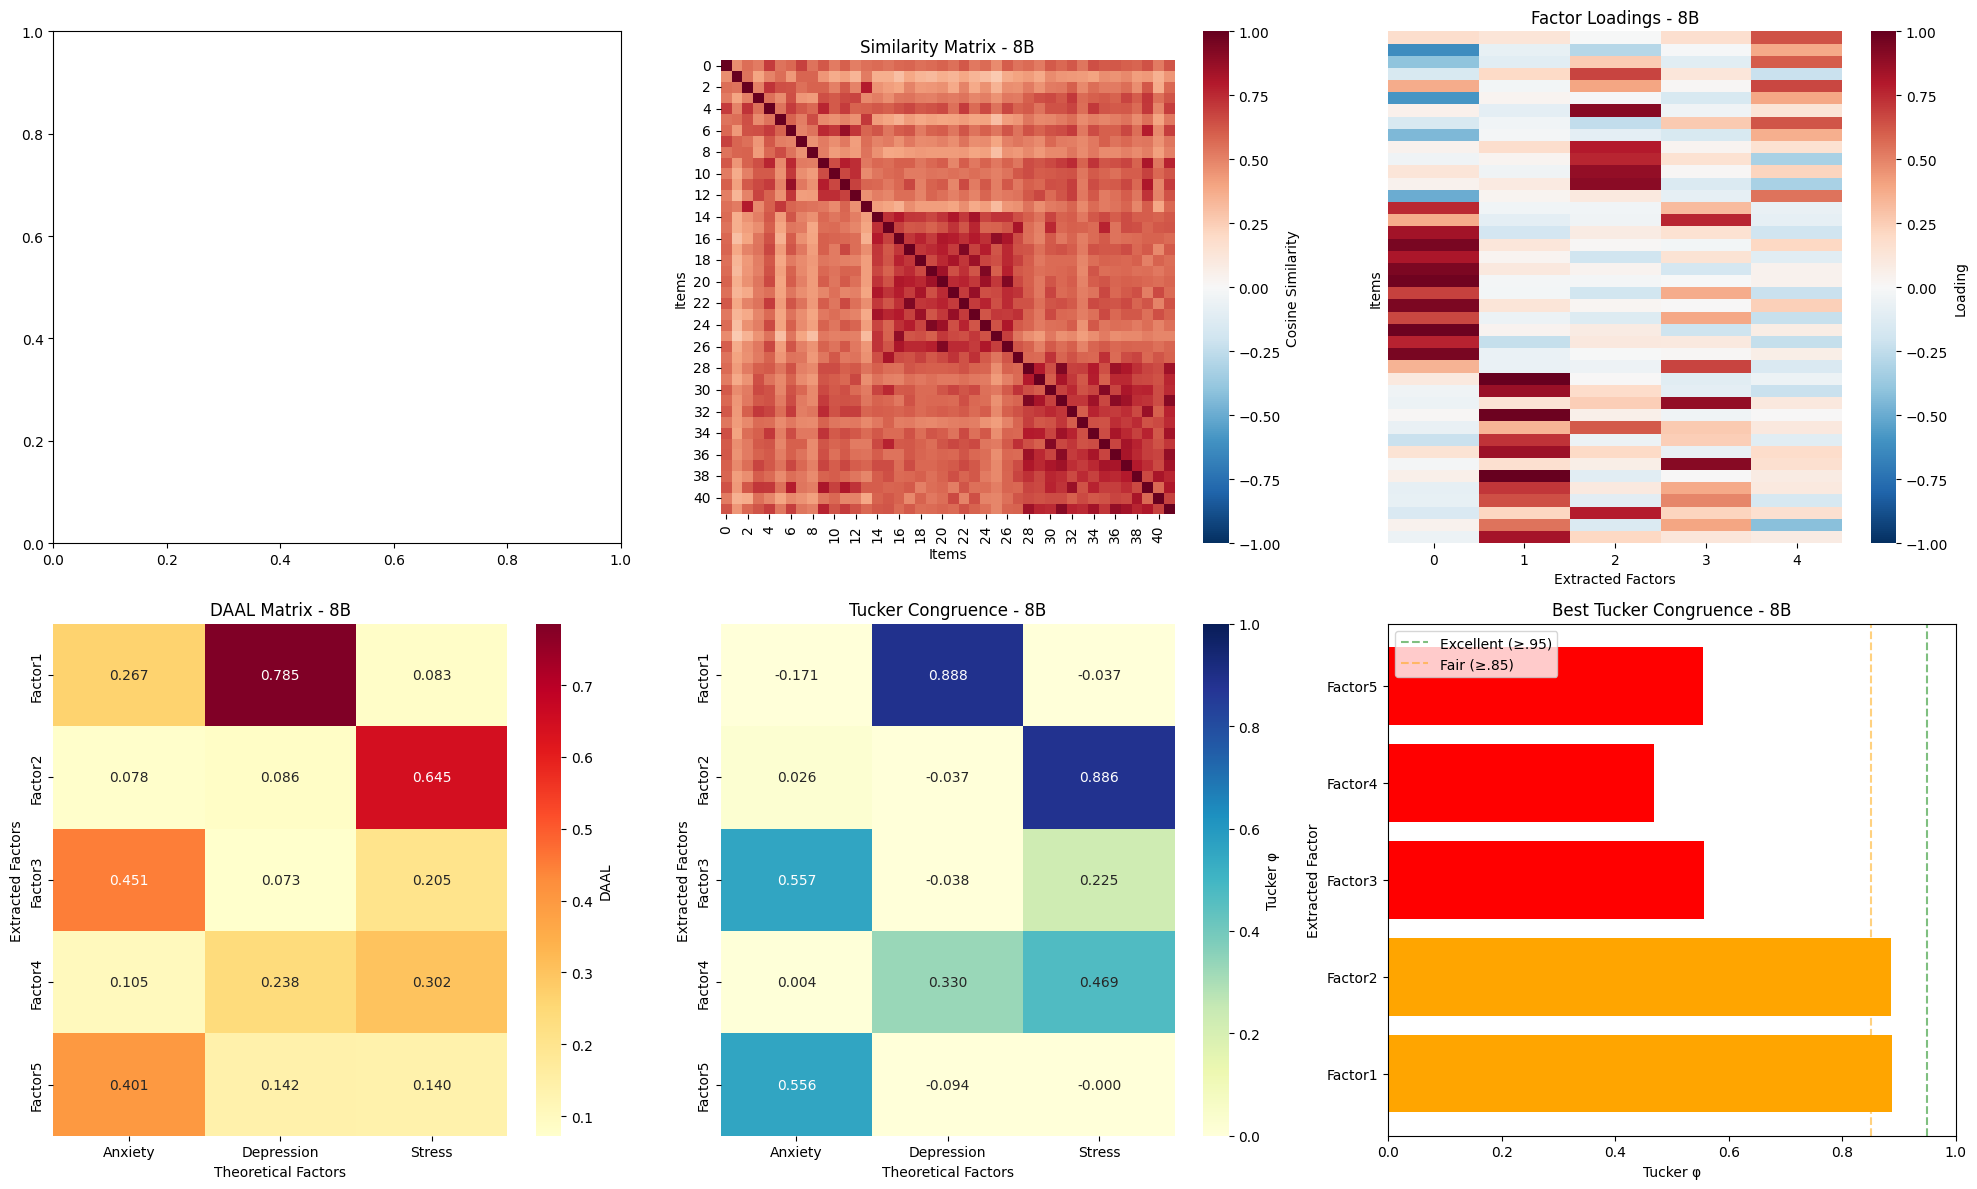

  ✓ Saved: results/visualizations_8B.png
✓ PFA COMPLETE FOR ALL MODELS


In [10]:
all_results = {}

for model_size in model_sizes:
    embeddings = all_embeddings[model_size]
    
    results = run_pfa_for_model(
        model_size=model_size,
        embeddings=embeddings,
        codes=codes,
        items=items,
        factors=factors,
        scoring=scoring,
        n_factors=N_FACTORS,
        rotation=ROTATION_METHOD,
        extraction_method=EXTRACTION_METHOD,
        eigen_criteria=EIGEN_CRITERIA,
        parallel_iter=PARALLEL_ITER,
        random_state=RANDOM_STATE,
        save_dir=SAVE_DIR
    )
    
    all_results[model_size] = results
    
    # Create visualizations
    create_visualizations(results, factors, codes, model_size, save_dir=SAVE_DIR)

print("✓ PFA COMPLETE FOR ALL MODELS")

In [ ]:
# ==============================================================================
# Run Traditional EFA on Empirical Data
# ==============================================================================

empirical_results = None

if empirical_data is not None:
    print(f"\n{'='*70}")
    print("RUNNING TRADITIONAL EFA ON EMPIRICAL DATA")
    print(f"{'='*70}")
    
    empirical_results = run_efa_on_data(
        data_label="Empirical",
        response_data=empirical_data,
        codes=codes,
        items=items,
        factors=factors,
        scoring=scoring,
        n_factors=N_FACTORS,
        rotation=ROTATION_METHOD,
        extraction_method=EXTRACTION_METHOD,
        eigen_criteria=EIGEN_CRITERIA,
        parallel_iter=PARALLEL_ITER,
        random_state=RANDOM_STATE,
        save_dir=SAVE_DIR
    )
    
    # Create visualizations for empirical data
    create_visualizations(empirical_results, factors, codes, "Empirical", 
                         save_dir=SAVE_DIR, data_type='empirical')
    
    print(f"\n✓ TRADITIONAL EFA COMPLETE")
else:
    print(f"\n{'='*70}")
    print("Empirical data not loaded - skipping traditional EFA")
    print(f"{'='*70}")

## Analyze Nearest Neighbors - All Models

Examine nearest neighbors in the original high-dimensional embedding space to validate semantic clustering.

In [11]:
# Select a sample item to analyze
sample_idx = 0  # First item

print("Finding nearest neighbors in original embedding space...")
print(f"\nSample item #{sample_idx}:")
print(f"  Code: {codes[sample_idx]}")
print(f"  Factor: {factors[sample_idx]}")
print(f"  Text: {items[sample_idx]}")

for model_size in model_sizes:
    embeddings = all_embeddings[model_size]
    print(f"{model_size} Model - Original {embeddings.shape[1]}D Space")
    
    # Compute cosine similarity between sample and all items
    # Note: embeddings are already processed through atomic-reversed encoding
    # For pure nearest neighbors, we could use original embeddings, but using
    # the processed ones ensures consistency with the PFA analysis
    similarities = cosine_similarity([embeddings[sample_idx]], embeddings)[0]
    
    # Find 5 most similar items (excluding itself)
    most_similar_indices = np.argsort(similarities)[::-1][1:6]
    
    print(f"5 Most similar items (by cosine similarity):")
    for rank, idx in enumerate(most_similar_indices, 1):
        print(f"  {rank}. [{factors[idx]}] {items[idx][:80]}...")
        print(f"      Similarity: {similarities[idx]:.4f}")

print("✓ Nearest neighbors analysis complete")

Finding nearest neighbors in original embedding space...

Sample item #0:
  Code: S1
  Factor: Stress
  Text: I found myself getting upset by quite trivial things.
8B Model - Original 4096D Space
5 Most similar items (by cosine similarity):
  1. [Stress] I found myself getting upset rather easily....
      Similarity: 0.9336
  2. [Stress] I found that I was very irritable....
      Similarity: 0.8543
  3. [Stress] I found myself getting agitated....
      Similarity: 0.8513
  4. [Stress] I found it hard to calm down after something upset me....
      Similarity: 0.8092
  5. [Stress] I tended to over-react to situations....
      Similarity: 0.7967
✓ Nearest neighbors analysis complete


## Within- vs Between-Construct Similarity Analysis (Milano et al. 2025)

Test whether items from the same theoretical factor are more similar than items from different factors.

**Method:**
- **Within-construct similarities**: Cosine similarities between items sharing the same factor
- **Between-construct similarities**: Cosine similarities between items from different factors
- **Statistical test**: Welch's t-test (unequal variances)
- **Effect size**: Cohen's d

This analysis provides empirical evidence for **construct validity**: if embeddings capture the theoretical factor structure, within-construct similarities should be significantly higher than between-construct similarities.

In [12]:
print("MILANO ET AL. (2025) WITHIN- vs BETWEEN-CONSTRUCT ANALYSIS")

from scipy.stats import ttest_ind

for model_size in model_sizes:
    print(f"\n{model_size} Model:")
    
    # Get similarity matrix from results
    sim_matrix = all_results[model_size]['similarity_matrix']
    n_items = len(factors)
    
    # Collect similarities (upper triangle only, i < j)
    within_sims = []
    between_sims = []
    
    for i in range(n_items):
        for j in range(i + 1, n_items):  # Upper triangle only
            sim = sim_matrix[i, j]
            
            if factors[i] == factors[j]:
                within_sims.append(sim)
            else:
                between_sims.append(sim)
    
    # Convert to arrays
    within_sims = np.array(within_sims)
    between_sims = np.array(between_sims)
    
    # Compute statistics
    mean_within = np.mean(within_sims)
    sd_within = np.std(within_sims, ddof=1)
    mean_between = np.mean(between_sims)
    sd_between = np.std(between_sims, ddof=1)
    mean_diff = mean_within - mean_between
    
    # Cohen's d (pooled standard deviation)
    pooled_sd = np.sqrt((sd_within**2 + sd_between**2) / 2)
    cohens_d = mean_diff / pooled_sd if pooled_sd > 0 else 0.0
    
    # Welch's t-test (unequal variances)
    t_stat, p_value = ttest_ind(within_sims, between_sims, equal_var=False)
    
    # Degrees of freedom (Welch-Satterthwaite)
    n1, n2 = len(within_sims), len(between_sims)
    s1_sq, s2_sq = sd_within**2, sd_between**2
    df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq/n1)**2/(n1-1) + (s2_sq/n2)**2/(n2-1))
    
    # Print results
    print(f"  Within-construct:  M = {mean_within:.3f}, SD = {sd_within:.3f}, n = {len(within_sims)}")
    print(f"  Between-construct: M = {mean_between:.3f}, SD = {sd_between:.3f}, n = {len(between_sims)}")
    print(f"  Mean difference: {mean_diff:.3f}")
    print(f"  Welch's t({df:.1f}) = {t_stat:.2f}, p = {p_value:.4e}")
    print(f"  Cohen's d = {cohens_d:.3f}")
    
    # Interpretation
    if p_value < 0.001:
        sig_text = "highly significant (p < .001)"
    elif p_value < 0.01:
        sig_text = "very significant (p < .01)"
    elif p_value < 0.05:
        sig_text = "significant (p < .05)"
    else:
        sig_text = "not significant (p ≥ .05)"
    
    if abs(cohens_d) >= 0.8:
        effect_text = "large effect"
    elif abs(cohens_d) >= 0.5:
        effect_text = "medium effect"
    elif abs(cohens_d) >= 0.2:
        effect_text = "small effect"
    else:
        effect_text = "negligible effect"
    
    print(f"\n  Interpretation: {sig_text}, {effect_text}")
    
    if mean_within > mean_between and p_value < 0.05:
        print(f"  ✓ Items from the same factor are significantly more similar.")
    elif mean_within < mean_between and p_value < 0.05:
        print(f"  ⚠ Items from different factors are MORE similar (unexpected!).")
    else:
        print(f"  ⚠ No significant difference in within- vs between-construct similarity.")

print("✓ MILANO ET AL. ANALYSIS COMPLETE")

MILANO ET AL. (2025) WITHIN- vs BETWEEN-CONSTRUCT ANALYSIS

8B Model:
  Within-construct:  M = 0.672, SD = 0.118, n = 273
  Between-construct: M = 0.548, SD = 0.087, n = 588
  Mean difference: 0.124
  Welch's t(413.7) = 15.55, p = 2.9350e-43
  Cohen's d = 1.199

  Interpretation: highly significant (p < .001), large effect
  ✓ Items from the same factor are significantly more similar.
✓ MILANO ET AL. ANALYSIS COMPLETE



Creating Milano et al. visualization...


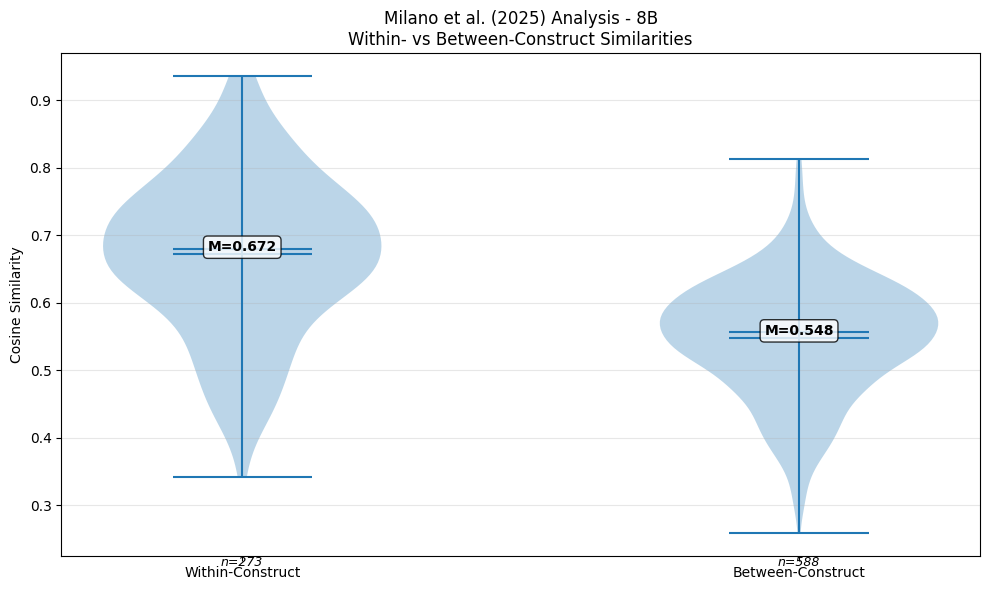

  ✓ Saved: results/milano_analysis_8B.png

✓ Milano et al. visualizations complete


In [13]:
# Visualize within vs between similarities
print("\nCreating Milano et al. visualization...")

for model_size in model_sizes:
    sim_matrix = all_results[model_size]['similarity_matrix']
    n_items = len(factors)
    
    # Collect similarities
    within_sims = []
    between_sims = []
    
    for i in range(n_items):
        for j in range(i + 1, n_items):
            sim = sim_matrix[i, j]
            if factors[i] == factors[j]:
                within_sims.append(sim)
            else:
                between_sims.append(sim)
    
    # Create violin plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    data = [within_sims, between_sims]
    positions = [1, 2]
    
    parts = ax.violinplot(data, positions=positions, showmeans=True, showmedians=True)
    
    ax.set_xticks(positions)
    ax.set_xticklabels(['Within-Construct', 'Between-Construct'])
    ax.set_ylabel('Cosine Similarity')
    ax.set_title(f'Milano et al. (2025) Analysis - {model_size}\nWithin- vs Between-Construct Similarities')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add mean values as text
    mean_within = np.mean(within_sims)
    mean_between = np.mean(between_sims)
    
    ax.text(1, mean_within, f'M={mean_within:.3f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.text(2, mean_between, f'M={mean_between:.3f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add sample sizes
    ax.text(1, ax.get_ylim()[0], f'n={len(within_sims)}', 
            ha='center', va='top', fontsize=9, style='italic')
    ax.text(2, ax.get_ylim()[0], f'n={len(between_sims)}', 
            ha='center', va='top', fontsize=9, style='italic')
    
    plt.tight_layout()
    plt.savefig(f'{SAVE_DIR}/milano_analysis_{model_size}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"  ✓ Saved: {SAVE_DIR}/milano_analysis_{model_size}.png")

print("\n✓ Milano et al. visualizations complete")

In [ ]:
# ==============================================================================
# Within- vs Between-Construct Analysis - Empirical Data
# ==============================================================================

if empirical_results is not None:
    print(f"\n{'='*70}")
    print("WITHIN- VS BETWEEN-CONSTRUCT ANALYSIS - EMPIRICAL DATA")
    print(f"{'='*70}")
    
    # Extract correlation matrix from empirical results
    corr_matrix = empirical_results['similarity_matrix']
    
    n_items = len(codes)
    within_corrs = []
    between_corrs = []
    
    # Collect upper triangle only (i < j) to avoid duplication
    for i in range(n_items):
        for j in range(i + 1, n_items):
            corr = corr_matrix[i, j]
            if factors[i] == factors[j]:
                within_corrs.append(corr)  # Same theoretical factor
            else:
                between_corrs.append(corr)  # Different factors
    
    # Descriptive statistics
    mean_within = np.mean(within_corrs)
    sd_within = np.std(within_corrs, ddof=1)
    mean_between = np.mean(between_corrs)
    sd_between = np.std(between_corrs, ddof=1)
    mean_diff = mean_within - mean_between
    
    # Welch's t-test (unequal variances)
    from scipy.stats import ttest_ind
    t_stat, p_value = ttest_ind(within_corrs, between_corrs, equal_var=False)
    
    # Cohen's d effect size
    pooled_sd = np.sqrt((sd_within**2 + sd_between**2) / 2)
    cohens_d = mean_diff / pooled_sd
    
    # Welch-Satterthwaite degrees of freedom
    n_within = len(within_corrs)
    n_between = len(between_corrs)
    df_welch = ((sd_within**2/n_within + sd_between**2/n_between)**2 / 
                ((sd_within**2/n_within)**2/(n_within-1) + (sd_between**2/n_between)**2/(n_between-1)))
    
    print(f"\n  Empirical Data:")
    print(f"    Within-construct correlations:")
    print(f"      Mean = {mean_within:.3f}, SD = {sd_within:.3f}, n = {n_within}")
    print(f"    Between-construct correlations:")
    print(f"      Mean = {mean_between:.3f}, SD = {sd_between:.3f}, n = {n_between}")
    print(f"    Mean difference: {mean_diff:.3f}")
    print(f"\n    Welch's t-test:")
    print(f"      t({df_welch:.1f}) = {t_stat:.3f}, p = {p_value:.2e}")
    print(f"    Cohen's d: {cohens_d:.3f}")
    
    # Interpretation
    if p_value < 0.001:
        sig_level = "p < .001"
    elif p_value < 0.01:
        sig_level = "p < .01"
    elif p_value < 0.05:
        sig_level = "p < .05"
    else:
        sig_level = "not significant"
    
    if abs(cohens_d) >= 0.8:
        effect_size = "large"
    elif abs(cohens_d) >= 0.5:
        effect_size = "medium"
    elif abs(cohens_d) >= 0.2:
        effect_size = "small"
    else:
        effect_size = "negligible"
    
    print(f"\n  Interpretation:")
    print(f"    Significance: {sig_level}")
    print(f"    Effect size: {effect_size}")
    
    # Validation check
    if mean_within > mean_between:
        print(f"    ✓ Within-construct correlations > Between-construct (expected)")
    else:
        print(f"    ⚠ Within-construct correlations ≤ Between-construct (unexpected!)")
    
    # Create visualization
    print(f"\n  Creating visualization...")
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Prepare data for violin plot
    within_data = pd.DataFrame({
        'correlation': within_corrs,
        'type': ['Within-Construct'] * len(within_corrs)
    })
    between_data = pd.DataFrame({
        'correlation': between_corrs,
        'type': ['Between-Construct'] * len(between_corrs)
    })
    plot_data = pd.concat([within_data, between_data], ignore_index=True)
    
    # Create violin plot
    sns.violinplot(data=plot_data, x='type', y='correlation', ax=ax, palette=['#2ecc71', '#e74c3c'])
    
    # Add mean markers and text
    ax.plot([0], [mean_within], 'D', color='darkgreen', markersize=10, label=f'Within Mean = {mean_within:.3f}')
    ax.plot([1], [mean_between], 'D', color='darkred', markersize=10, label=f'Between Mean = {mean_between:.3f}')
    
    # Add sample sizes
    ax.text(0, ax.get_ylim()[0], f'n={n_within}', ha='center', va='top', fontsize=10)
    ax.text(1, ax.get_ylim()[0], f'n={n_between}', ha='center', va='top', fontsize=10)
    
    ax.set_xlabel('Comparison Type', fontsize=12)
    ax.set_ylabel('Correlation', fontsize=12)
    ax.set_title(f'Milano et al. (2025) Analysis - Empirical Data\\nWithin- vs Between-Construct Correlations', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    filepath = f'{SAVE_DIR}/milano_analysis_Empirical.png'
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"  ✓ Saved: {filepath}")
    print(f"\n✓ WITHIN/BETWEEN ANALYSIS COMPLETE - EMPIRICAL DATA")
else:
    print(f"\n{'='*70}")
    print("Empirical results not available - skipping Within/Between analysis")
    print(f"{'='*70}")

## Factor Separation Analysis

Detailed breakdown of within- and between-factor similarities by individual factors.

**Metrics:**
- **Within-factor similarity**: Average similarity for items within each factor
- **Between-factor similarity**: Average similarity for each pair of different factors  
- **Separation ratio**: within_mean / between_mean (>1.0 indicates good separation)

This complements the Milano et al. analysis by showing which specific factors separate best and which factor pairs are most confusable.

In [14]:
print("FACTOR SEPARATION ANALYSIS")
print("=" * 70)

for model_size in model_sizes:
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Factor Separation Metrics")
    print(f"{'='*70}")
    
    # Use PFA similarity matrix (atomic-reversed encoded)
    sim_matrix = all_results[model_size]['similarity_matrix']
    
    # Initialize accumulators
    unique_factors = sorted(set(factors))
    within_factor_sims = {factor: [] for factor in unique_factors}
    between_factor_sims = []
    
    # Compute within-factor and between-factor similarities
    for i in range(len(factors)):
        for j in range(i + 1, len(factors)):
            similarity = sim_matrix[i, j]
            
            if factors[i] == factors[j]:
                within_factor_sims[factors[i]].append(similarity)
            else:
                between_factor_sims.append(similarity)
    
    # Compute overall metrics
    all_within_sims = []
    for factor_sims in within_factor_sims.values():
        all_within_sims.extend(factor_sims)
    
    within_mean = np.mean(all_within_sims)
    between_mean = np.mean(between_factor_sims)
    separation_ratio = within_mean / between_mean
    
    # Print overall results
    print(f"\nOverall Separation Metrics:")
    print(f"  Within-factor similarity:  {within_mean:.4f}")
    print(f"  Between-factor similarity: {between_mean:.4f}")
    print(f"  Separation ratio:          {separation_ratio:.4f}")
    print(f"    {'(Good separation - factors cluster together!)' if separation_ratio > 1.0 else '(Poor separation - factors overlap)'}")
    
    # Print per-factor breakdown
    print(f"\nPer-Factor Within-Similarity:")
    for factor in unique_factors:
        if len(within_factor_sims[factor]) > 0:
            factor_mean = np.mean(within_factor_sims[factor])
            factor_std = np.std(within_factor_sims[factor], ddof=1)
            n_pairs = len(within_factor_sims[factor])
            print(f"  {factor:12s}: {factor_mean:.4f} ± {factor_std:.4f}  (n={n_pairs} pairs)")
    
    # Compute pairwise between-factor similarities
    print(f"\nBetween-Factor Similarities:")
    factor_pairs = {}
    for i in range(len(factors)):
        for j in range(i + 1, len(factors)):
            if factors[i] != factors[j]:
                pair = tuple(sorted([factors[i], factors[j]]))
                if pair not in factor_pairs:
                    factor_pairs[pair] = []
                factor_pairs[pair].append(sim_matrix[i, j])
    
    for pair in sorted(factor_pairs.keys()):
        pair_mean = np.mean(factor_pairs[pair])
        pair_std = np.std(factor_pairs[pair], ddof=1)
        n_pairs = len(factor_pairs[pair])
        print(f"  {pair[0]:12s} vs {pair[1]:12s}: {pair_mean:.4f} ± {pair_std:.4f}  (n={n_pairs} pairs)")

print(f"\n{'='*70}")
print("✓ Factor separation analysis complete!")
print(f"{'='*70}")

FACTOR SEPARATION ANALYSIS

8B Model - Factor Separation Metrics

Overall Separation Metrics:
  Within-factor similarity:  0.6721
  Between-factor similarity: 0.5480
  Separation ratio:          1.2263
    (Good separation - factors cluster together!)

Per-Factor Within-Similarity:
  Anxiety     : 0.5674 ± 0.1065  (n=91 pairs)
  Depression  : 0.7178 ± 0.0833  (n=91 pairs)
  Stress      : 0.7310 ± 0.0835  (n=91 pairs)

Between-Factor Similarities:
  Anxiety      vs Depression  : 0.4986 ± 0.0900  (n=196 pairs)
  Anxiety      vs Stress      : 0.5680 ± 0.0869  (n=196 pairs)
  Depression   vs Stress      : 0.5776 ± 0.0567  (n=196 pairs)

✓ Factor separation analysis complete!


## Summary Report

Display key diagnostics and results for all models.

In [15]:
print("SUMMARY")

for model_size in model_sizes:
    results = all_results[model_size]
    print(f"\n{model_size}:")
    
    if 'diagnostics' in results:
        diag = results['diagnostics'].iloc[0]
        print(f"  Items: {diag['n_items']}")
        print(f"  Factors: {diag['n_factors_extracted']}")
        print(f"  Rotation: {diag['rotation']}")
        if 'kmo' in diag:
            print(f"  KMO: {diag['kmo']:.3f}")
        if 'bartlett_p' in diag:
            print(f"  Bartlett p: {diag['bartlett_p']:.4e}")
        print(f"  Variance: {diag['variance_explained']:.1%}")
    
    if 'daal_assignments' in results:
        print("\n  DAAL assignments:")
        for _, row in results['daal_assignments'].iterrows():
            print(f"    {row['extracted']} → {row['assigned_to']} (DAAL={row['daal']:.3f})")
    
    if 'tucker_best' in results:
        print("\n  Tucker congruence:")
        for _, row in results['tucker_best'].iterrows():
            print(f"    {row['extracted']} ↔ {row['best_match']} (φ={row['tucker_phi']:.3f})")

print(f"\nResults saved to: {SAVE_DIR}/")

SUMMARY

8B:
  Items: 42
  Factors: 5
  Rotation: oblimin
  KMO: 0.843
  Bartlett p: 4.1979e-306
  Variance: 75.7%

  DAAL assignments:
    Factor1 → Depression (DAAL=0.785)
    Factor2 → Stress (DAAL=0.645)
    Factor3 → Anxiety (DAAL=0.451)
    Factor4 → Stress (DAAL=0.302)
    Factor5 → Anxiety (DAAL=0.401)

  Tucker congruence:
    Factor1 ↔ Depression (φ=0.888)
    Factor2 ↔ Stress (φ=0.886)
    Factor3 ↔ Anxiety (φ=0.557)
    Factor4 ↔ Stress (φ=0.469)
    Factor5 ↔ Anxiety (φ=0.556)

Results saved to: results/


## Automatic Factor Naming with LLM

Generate semantic names for EFA-extracted factors using Qwen2.5-1.5B-Instruct.

**Approach:**
1. For each extracted factor, identify the top 10 items with highest absolute loadings
2. Extract the text of these high-loading items
3. Feed the item text to Qwen2.5-1.5B-Instruct LLM with a prompt
4. LLM generates a concise semantic label (single word or short phrase) describing what the items measure
5. Store factor name mappings in `factor_name_mappings` dictionary

**Prompt Format:**
```
"These are items from a psychological scale that all load strongly on the same latent factor: [item1 | item2 | ...]. 
Provide a single word or very short phrase that best describes the psychological construct these items are measuring."
```

**Advantages over vocabulary-based naming:**
- Uses actual scale items that define each factor (not external vocabulary)
- More psychologically valid (factors are defined by their indicators)
- No need to load separate word embeddings
- Direct relationship between loadings and names

**Note:** Generated names are stored in the `factor_name_mappings` dictionary. Original results in `all_results` remain unchanged.

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

print("Loading word list for nearest neighbor factor naming...")

# Path to word list (used only if generating embeddings)
word_list_path = "word_lists/constructs.csv"

# Check if any model has pregenerated embeddings specified
has_pregenerated = any(model_size in PREGENERATED_WORD_EMBEDDINGS for model_size in [m.split('-')[-1] for m in MODEL_NAMES])

# If pregenerated embeddings exist, load words from there instead of CSV
if has_pregenerated:
    # Get first pregenerated path to extract word list
    first_model_size = [m.split('-')[-1] for m in MODEL_NAMES][0]
    if first_model_size in PREGENERATED_WORD_EMBEDDINGS:
        pregenerated_path = PREGENERATED_WORD_EMBEDDINGS[first_model_size]
        if os.path.exists(pregenerated_path):
            print(f"Loading words from pregenerated embeddings: {pregenerated_path}")
            try:
                data = np.load(pregenerated_path, allow_pickle=True)
                if 'words' in data:
                    words = data['words'].tolist()
                    print(f"✓ Loaded {len(words)} words from pregenerated embeddings")
                else:
                    print(f"✗ 'words' key not found in {pregenerated_path}")
                    print(f"  Available keys: {list(data.keys())}")
                    print(f"  Falling back to {word_list_path}")
                    words_df = pd.read_csv(word_list_path, header=None, names=['word'])
                    words = words_df['word'].tolist()
                    print(f"✓ Loaded {len(words)} words from {word_list_path}")
            except Exception as e:
                print(f"✗ Error loading words from pregenerated: {e}")
                print(f"  Falling back to {word_list_path}")
                words_df = pd.read_csv(word_list_path, header=None, names=['word'])
                words = words_df['word'].tolist()
                print(f"✓ Loaded {len(words)} words from {word_list_path}")
        else:
            print(f"✗ Pregenerated path not found: {pregenerated_path}")
            print(f"  Loading from {word_list_path}")
            words_df = pd.read_csv(word_list_path, header=None, names=['word'])
            words = words_df['word'].tolist()
            print(f"✓ Loaded {len(words)} words from {word_list_path}")
    else:
        # Load from CSV
        try:
            words_df = pd.read_csv(word_list_path, header=None, names=['word'])
            words = words_df['word'].tolist()
            print(f"✓ Loaded {len(words)} words from {word_list_path}")
        except Exception as e:
            print(f"✗ Error loading word list: {e}")
            print("  Nearest neighbor method will be skipped.")
            words = None
else:
    # No pregenerated embeddings - load words from CSV
    try:
        words_df = pd.read_csv(word_list_path, header=None, names=['word'])
        words = words_df['word'].tolist()
        print(f"✓ Loaded {len(words)} words from {word_list_path}")
    except Exception as e:
        print(f"✗ Error loading word list: {e}")
        print("  Nearest neighbor method will be skipped.")
        words = None

# Generate/load embeddings for words
if words is not None:
    all_word_embeddings = {}
    
    for model_size in model_sizes:
        print(f"\n{model_size} Model - Word Embeddings:")
        
        # Check if pregenerated embeddings are specified for this model
        if model_size in PREGENERATED_WORD_EMBEDDINGS:
            word_emb_path = PREGENERATED_WORD_EMBEDDINGS[model_size]
            if os.path.exists(word_emb_path):
                print(f"  Loading pregenerated from {word_emb_path}...")
                try:
                    data = np.load(word_emb_path, allow_pickle=True)
                    
                    # Try different possible key names for embeddings
                    word_embeddings = None
                    for key in ['word_embeddings', 'embeddings', 'vectors', 'arr_0']:
                        if key in data:
                            word_embeddings = data[key]
                            print(f"  ✓ Loaded from key '{key}': {word_embeddings.shape}")
                            break
                    
                    if word_embeddings is None:
                        print(f"  ✗ Could not find embeddings in file")
                        print(f"  Available keys: {list(data.keys())}")
                        print(f"  Falling back to generation...")
                        word_embeddings = None
                    else:
                        # Verify shape matches word count
                        if word_embeddings.shape[0] != len(words):
                            print(f"  ⚠ WARNING: Embedding count ({word_embeddings.shape[0]}) != word count ({len(words)})")
                        
                        all_word_embeddings[model_size] = word_embeddings
                        continue
                        
                except Exception as e:
                    print(f"  ✗ Error loading pregenerated embeddings: {e}")
                    print(f"  Falling back to generation...")
            else:
                print(f"  ⚠ Pregenerated path specified but not found: {word_emb_path}")
                print(f"  Falling back to generation...")
        
        # No pregenerated path or file doesn't exist - check cache then generate
        word_emb_path = f"embeddings/word_embeddings_{model_size}.npz"
        
        if os.path.exists(word_emb_path):
            print(f"  Loading from cache: {word_emb_path}...")
            data = np.load(word_emb_path, allow_pickle=True)
            word_embeddings = data['word_embeddings']
            print(f"  ✓ Loaded: {word_embeddings.shape}")
        else:
            # Generate embeddings using the same model
            print(f"  Generating embeddings for {len(words)} words...")
            
            # Get the model (already loaded earlier)
            model_cache_name = MODEL_NAMES[model_sizes.index(model_size)].replace('/', '--')
            snapshots_dir = f"/home/devon7y/links/scratch/huggingface/models--{model_cache_name}/snapshots"
            snapshot_dirs = glob.glob(f"{snapshots_dir}/*")
            
            if snapshot_dirs:
                snapshot_path = snapshot_dirs[0]
                model = SentenceTransformer(snapshot_path, device=device)
                
                # Encode words in batches
                word_embeddings = model.encode(
                    words, 
                    show_progress_bar=True, 
                    batch_size=256,
                    convert_to_numpy=True, 
                    normalize_embeddings=False
                )
                
                print(f"  ✓ Generated: {word_embeddings.shape}")
                
                # Save for future use
                np.savez(word_emb_path, word_embeddings=word_embeddings, words=words)
                print(f"  ✓ Saved to {word_emb_path}")
            else:
                print(f"  ✗ Could not find model snapshots")
                word_embeddings = None
        
        all_word_embeddings[model_size] = word_embeddings
    
    print(f"\n✓ Word embeddings ready for {len(all_word_embeddings)} model(s)")
else:
    all_word_embeddings = {}
    print("\n⚠ Word embeddings not available - nearest neighbor method will be skipped")

Loading word list for nearest neighbor factor naming...
Loading words from pregenerated embeddings: embeddings/2257_constructs_8B.npz
✓ Loaded 2258 words from pregenerated embeddings

8B Model - Word Embeddings:
  Loading pregenerated from embeddings/2257_constructs_8B.npz...
  ✓ Loaded from key 'embeddings': (2258, 4096)

✓ Word embeddings ready for 1 model(s)


In [ ]:
import os
from openai import OpenAI
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

print("Setting up HuggingFace API client for automatic factor naming...")

# Check if HF_TOKEN is set
if "HF_TOKEN" not in os.environ:
    print("\n✗ Error: HF_TOKEN environment variable not set!")
    print("  Please set your HuggingFace token in the setup cell above.")
    print("\nSkipping automatic factor naming...")
    client = None
else:
    # Initialize OpenAI client - simple, like test script
    client = OpenAI(
        base_url="https://router.huggingface.co/v1",
        api_key=os.environ["HF_TOKEN"],
    )
    print("✓ HuggingFace API client initialized")
    print(f"  Using model: Qwen/Qwen3-235B-A22B-Instruct-2507:novita")

# Proceed with factor naming if client is available
if client is not None:
    print(f"\n{'='*70}")
    print("COMPARING TWO FACTOR NAMING APPROACHES")
    print(f"{'='*70}")
    print("\nMethod 1: Direct Scale Items (with psychological context)")
    print("Method 2: Nearest Neighbor Words (vocabulary-based, no context)")
    print(f"{'='*70}\n")
    
    # Store factor name mappings for both methods
    factor_name_mappings_direct = {}
    factor_name_mappings_nn = {}
    
    # Check if word embeddings are available
    nn_available = 'all_word_embeddings' in dir() and len(all_word_embeddings) > 0 and 'words' in dir() and words is not None
    
    # Process each model
    for model_size in model_sizes:
        print(f"\n{'='*70}")
        print(f"{model_size} Model - Automatic Factor Naming")
        print(f"{'='*70}")
        
        # Get loadings and embeddings for this model
        loadings_df = all_results[model_size]['loadings']
        n_factors = loadings_df.shape[1]
        embeddings = all_embeddings[model_size]
        
        factor_name_mappings_direct[model_size] = {}
        factor_name_mappings_nn[model_size] = {}
        
        # Get word embeddings if available
        if nn_available:
            word_embeddings = all_word_embeddings[model_size]
            print(f"\n✓ Word embeddings available: {word_embeddings.shape}")
        else:
            print(f"\n⚠ Word embeddings not available - only Method 1 will run")
        
        # Process each factor
        for factor_name in loadings_df.columns:
            print(f"\n{'='*70}")
            print(f"{factor_name}:")
            print(f"{'='*70}")
            
            # Get absolute loadings for this factor
            factor_loadings = loadings_df[factor_name].abs()
            
            # Find top 10 items with highest absolute loadings
            top_indices = factor_loadings.nlargest(10).index
            
            # ===== METHOD 1: DIRECT SCALE ITEMS =====
            print(f"\n[METHOD 1: Direct Scale Items]")
            
            # Get the actual item text for these top-loading items
            top_items_text = []
            print(f"Top 10 loading items:")
            for i, code in enumerate(top_indices, 1):
                item_idx = codes.index(code)
                item_text = items[item_idx]
                loading_val = loadings_df.loc[code, factor_name]
                top_items_text.append(item_text)
                print(f"  {i}. (λ={loading_val:.3f}): {item_text[:70]}...")
            
            # Create prompt from top 5 items
            items_for_prompt = " | ".join([item[:120] for item in top_items_text[:5]])
            
            user_prompt_direct = f"These are items from a psychological scale that all load strongly on the same latent factor: {items_for_prompt} Provide a single word or very short phrase (maximum 3 words) that best describes the psychological construct these items are measuring. Provide ONLY the label, nothing else."
            
            # System prompt
            system_prompt = "You are a helpful assistant that provides concise, one or two-word summaries."
            
            # Print full prompts
            print(f"\n  [DEBUG] System prompt:")
            print(f"    '{system_prompt}'")
            print(f"\n  [DEBUG] User prompt:")
            print(f"    {user_prompt_direct}")
            print(f"\n  [DEBUG] Prompt length: {len(user_prompt_direct)} characters")
            
            # Simple API call
            completion = client.chat.completions.create(
                model="Qwen/Qwen3-235B-A22B-Instruct-2507:novita",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt_direct}
                ],
                max_tokens=10,
                temperature=0,
            )
            
            # Extract result
            generated_text_direct = completion.choices[0].message.content
            
            # Clean generated name
            generated_name_direct = generated_text_direct.strip()
            generated_name_direct = re.sub(r'^["\'\s]+|["\'\s]+$', '', generated_name_direct)
            generated_name_direct = re.sub(r'[.,;:!?]+$', '', generated_name_direct)
            generated_name_direct = generated_name_direct.split('\n')[0].strip()
            generated_name_direct = re.sub(r'^\*+|\*+$', '', generated_name_direct)
            
            if len(generated_name_direct) > 50:
                generated_name_direct = generated_name_direct[:50].strip()
            if not generated_name_direct or len(generated_name_direct) < 2:
                generated_name_direct = factor_name
            
            print(f"\n  Method 1 Result: '{generated_name_direct}'")
            factor_name_mappings_direct[model_size][factor_name] = generated_name_direct
            
            # ===== METHOD 2: NEAREST NEIGHBOR =====
            if nn_available and word_embeddings is not None:
                print(f"\n[METHOD 2: Nearest Neighbor Words]")
                
                # Compute factor centroid from top 10 items
                top_item_indices = [codes.index(code) for code in top_indices]
                factor_embeddings = embeddings[top_item_indices]
                
                # Normalize embeddings
                factor_embeddings_norm = factor_embeddings / np.linalg.norm(factor_embeddings, axis=1, keepdims=True)
                
                # Compute centroid (mean)
                centroid = np.mean(factor_embeddings_norm, axis=0)
                centroid_norm = centroid / np.linalg.norm(centroid)
                
                print(f"Computed centroid from {len(top_item_indices)} items (norm={np.linalg.norm(centroid):.4f})")
                
                # Find top 10 nearest neighbor words
                similarities = cosine_similarity([centroid_norm], word_embeddings)[0]
                top_word_indices = np.argsort(similarities)[::-1][:10]
                top_words = [words[idx] for idx in top_word_indices]
                
                print(f"Top 10 nearest neighbor words:")
                for i, (word_idx, word) in enumerate(zip(top_word_indices, top_words), 1):
                    sim = similarities[word_idx]
                    print(f"  {i}. {word:<20} (similarity={sim:.4f})")
                
                # Create prompt with nearest neighbor words
                words_list = ", ".join(top_words)
                user_prompt_nn = f"These are items from a psychological scale that all load strongly on the same latent factor: {words_list} Provide a single word or very short phrase (maximum 3 words) that best describes the psychological construct these items are measuring. Provide ONLY the label, nothing else."
                
                # Print full prompts
                print(f"\n  [DEBUG] System prompt:")
                print(f"    '{system_prompt}'")
                print(f"\n  [DEBUG] User prompt:")
                print(f"    {user_prompt_nn}")
                print(f"\n  [DEBUG] Prompt length: {len(user_prompt_nn)} characters")
                
                # Simple API call
                completion = client.chat.completions.create(
                    model="Qwen/Qwen3-235B-A22B-Instruct-2507:novita",
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": user_prompt_nn}
                    ],
                    max_tokens=10,
                    temperature=0,
                )
                
                # Extract result
                generated_text_nn = completion.choices[0].message.content
                
                # Clean generated name
                generated_name_nn = generated_text_nn.strip()
                generated_name_nn = re.sub(r'^["\'\s]+|["\'\s]+$', '', generated_name_nn)
                generated_name_nn = re.sub(r'[.,;:!?]+$', '', generated_name_nn)
                generated_name_nn = generated_name_nn.split('\n')[0].strip()
                generated_name_nn = re.sub(r'^\*+|\*+$', '', generated_name_nn)
                
                if len(generated_name_nn) > 50:
                    generated_name_nn = generated_name_nn[:50].strip()
                if not generated_name_nn or len(generated_name_nn) < 2:
                    generated_name_nn = factor_name
                
                print(f"\n  Method 2 Result: '{generated_name_nn}'")
                factor_name_mappings_nn[model_size][factor_name] = generated_name_nn
                
                # Show comparison
                print(f"\n  {'─'*70}")
                print(f"  COMPARISON for {factor_name}:")
                print(f"  {'─'*70}")
                print(f"  Method 1 (Scale Items):  '{generated_name_direct}'")
                print(f"  Method 2 (Nearest Words): '{generated_name_nn}'")
                print(f"  {'─'*70}")
            else:
                factor_name_mappings_nn[model_size][factor_name] = "(not available)"
    
    print(f"\n{'='*70}")
    print("✓ Automatic factor naming complete!")
    print(f"{'='*70}")
    
    # Display summary comparison
    print("\n" + "="*70)
    print("FACTOR NAME COMPARISON SUMMARY")
    print("="*70)
    
    for model_size in model_sizes:
        print(f"\n{model_size} Model:")
        print(f"{'─'*70}")
        print(f"{'Factor':<12} {'Method 1 (Items)':<25} {'Method 2 (NN Words)':<25}")
        print(f"{'─'*70}")
        
        for factor_name in sorted(factor_name_mappings_direct[model_size].keys()):
            name_direct = factor_name_mappings_direct[model_size][factor_name]
            name_nn = factor_name_mappings_nn[model_size].get(factor_name, "N/A")
            print(f"{factor_name:<12} {name_direct:<25} {name_nn:<25}")
        
        print(f"{'─'*70}")
    
    # Store both mappings
    print("\nNote: Both methods' results are stored:")
    print("  - 'factor_name_mappings_direct' (Method 1: Scale Items)")
    print("  - 'factor_name_mappings_nn' (Method 2: Nearest Neighbors)")
    print("  Original results in 'all_results' remain unchanged.")
    
else:
    print("\n⚠ Skipping automatic factor naming due to missing HF_TOKEN.")

In [ ]:
# ============================================================================
# Setup for HuggingFace API Factor Naming
# ============================================================================

import os
import sys

print("Setting up HuggingFace API environment...")

# Set HF_TOKEN
os.environ['HF_TOKEN'] = 'YOUR_HF_TOKEN_HERE'
print("✓ HF_TOKEN set")

# Check if openai package is installed
try:
    import openai
    print(f"✓ openai package installed (version {openai.__version__})")
except ImportError:
    print("⚠ openai package not found - installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "openai"])
    print("✓ openai package installed")
    print("  Please restart the kernel (Kernel → Restart Kernel) and re-run all cells")

print("\n✓ Environment ready for HuggingFace API calls")

## T-SNE Visualizations: Original Factors vs EFA-Extracted Factors

Create T-SNE visualizations comparing original theoretical factor assignments with EFA-extracted factor assignments.

**Two-plot comparison:**
- **Plot 1 (Top)**: Items colored by original theoretical factors (from CSV 'factor' column)
- **Plot 2 (Bottom)**: Items colored by extracted EFA factors (assigned by highest loading)
  - Uses LLM-generated factor names if available
  - Falls back to "Factor1", "Factor2", etc. if LLM naming hasn't run

**Visualization details:**
- 2D visualization via t-SNE dimensionality reduction
- Color-coded by factor with item codes labeled
- Separate files saved for each visualization type

In [ ]:
# Create factor assignments based on highest loadings
print("Creating factor assignments from EFA loadings...")

factor_assignments = {}

for model_size in model_sizes:
    loadings_df = all_results[model_size]['loadings']
    
    # For each item, find the factor with highest absolute loading
    item_to_factor = {}
    
    for item_code in loadings_df.index:
        # Get absolute loadings for this item across all factors
        abs_loadings = loadings_df.loc[item_code].abs()
        # Find factor with highest loading
        assigned_factor = abs_loadings.idxmax()
        item_to_factor[item_code] = assigned_factor
    
    # Group items by their assigned factors
    factor_items = {}
    for factor_name in loadings_df.columns:
        # Find all items assigned to this factor
        assigned_items = [
            {'index': codes.index(code), 'code': code}
            for code, assigned_f in item_to_factor.items()
            if assigned_f == factor_name
        ]
        factor_items[factor_name] = assigned_items
    
    factor_assignments[model_size] = factor_items
    
    # Display summary
    print(f"\n{model_size}:")
    for factor_name, items_list in factor_items.items():
        # Get display name (LLM-generated or default)
        if 'factor_name_mappings' in dir() and model_size in factor_name_mappings:
            display_name = factor_name_mappings[model_size].get(factor_name, factor_name)
        else:
            display_name = factor_name
        
        print(f"  {factor_name} ('{display_name}'): {len(items_list)} items")

print("✓ Factor assignments created!")

In [ ]:
# Import visualization libraries
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Prepare data for T-SNE (same across all models)
print("Preparing data for T-SNE...")
print(f"Number of items: {len(factors)}")

# Get unique factors for legend
unique_factors = sorted(set(factors))
print(f"Factors: {unique_factors}")

# Create a color map for the personality factors
import matplotlib.cm as cm
colors_map = cm.get_cmap('tab10', len(unique_factors))
factor_to_color = {factor: colors_map(i) for i, factor in enumerate(unique_factors)}

# Run T-SNE and create visualizations for all models
print("Running T-SNE for all models...")
print("=" * 70)

all_tsne_embeddings = {}

for model_size, embeddings in all_embeddings.items():
    print(f"\n{'='*70}")
    print(f"Running T-SNE for {model_size} model...")
    print(f"{'='*70}")
    print(f"Input shape: {embeddings.shape}")
    
    # Run T-SNE dimensionality reduction
    tsne = TSNE(
        n_components=2,      # Reduce to 2D
        perplexity=25,       # Balance local vs global structure
        max_iter=1000,       # Number of iterations
        random_state=42,     # For reproducibility
        verbose=1            # Show progress
    )
    
    # Transform high-D embeddings to 2D
    embeddings_2d = tsne.fit_transform(embeddings)
    all_tsne_embeddings[model_size] = embeddings_2d
    
    print(f"✓ T-SNE complete! 2D embeddings shape: {embeddings_2d.shape}")

print(f"\n{'='*70}")
print(f"✓ T-SNE complete for all {len(all_tsne_embeddings)} models!")
print(f"{'='*70}")

# Create T-SNE scatter plots for all models
print("Creating T-SNE visualizations...")
print("=" * 70)

# Create plots directory if it doesn't exist
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)
print(f"Plots will be saved to: {plots_dir}/")

# Generate timestamp for filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Determine number of models
num_models = len(all_tsne_embeddings)
print(f"Creating plots for {num_models} model(s)...")

# Check if we have any models to plot
if num_models == 0:
    print("\n⚠ WARNING: No T-SNE embeddings available to plot!")
    print("  Please run the T-SNE computation cells first.")
    print("\nSkipping visualization...")
else:
    # Check if EFA factor assignments are available
    factor_assignments_available = 'factor_assignments' in dir() and len(factor_assignments) > 0
    
    if not factor_assignments_available:
        print("\n⚠ WARNING: EFA factor assignments not available!")
        print("  Please run the PCA analysis cell first.")
        print("  Will show original factor coloring only.\n")
    
    # Create main combined plot with 2 rows (if PCA assignments available)
    if factor_assignments_available:
        # 2 rows: top = original factors, bottom = EFA factors
        fig_width = min(24, 8 * num_models)
        fig, axes = plt.subplots(2, min(3, num_models), figsize=(fig_width, 16))
        
        # Handle case of single model
        if min(3, num_models) == 1:
            axes = axes.reshape(2, 1)
    else:
        # Single row: original factors only
        fig_width = min(24, 8 * num_models)
        fig, axes = plt.subplots(1, min(3, num_models), figsize=(fig_width, 8))
        
        if min(3, num_models) == 1:
            axes = [axes]
    
    # Plot each model
    for idx, (model_size, embeddings_2d) in enumerate(sorted(all_tsne_embeddings.items())):
        if idx >= 3:  # Only plot first 3 models
            break
        
        # Get embedding dimension for titles
        embedding_dim = all_embeddings[model_size].shape[1]
        
        # ===== ROW 1: Original Factors =====
        if factor_assignments_available:
            ax = axes[0, idx]
        else:
            ax = axes[idx] if isinstance(axes, list) else axes
        
        # Plot each original factor with a different color
        for factor in unique_factors:
            indices = [i for i, f in enumerate(factors) if f == factor]
            ax.scatter(
                embeddings_2d[indices, 0],
                embeddings_2d[indices, 1],
                c=[factor_to_color[factor]],
                label=factor,
                alpha=0.6,
                s=80,
                edgecolors='white',
                linewidth=0.5
            )
        
        # Add labels
        for i in range(len(embeddings_2d)):
            ax.annotate(
                codes[i],
                (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                fontsize=7,
                alpha=0.7,
                ha='center',
                va='bottom',
                xytext=(0, 3),
                textcoords='offset points'
            )
        
        ax.set_xlabel('T-SNE Component 1', fontsize=11)
        ax.set_ylabel('T-SNE Component 2', fontsize=11)
        ax.set_title(
            f'{model_size} Model - Original Factors\n({embedding_dim}D → 2D)',
            fontsize=13,
            fontweight='bold'
        )
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Add legend to rightmost plot
        if idx == min(2, num_models - 1):
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        
        # ===== ROW 2: EFA Factors =====
        if factor_assignments_available:
            ax = axes[1, idx]
            
            # Get component assignments for this model
            factor_items = factor_assignments[model_size]
            n_factors = len(factor_items)
            
            # Create color map for components
            factor_colors_map = plt.cm.get_cmap('tab10', n_factors)
            factor_names = sorted(factor_items.keys())
            efa_factor_to_color = {comp: factor_colors_map(i) for i, comp in enumerate(factor_names)}
            
            # Plot each component with a different color
            for factor_name in factor_names:
                # Get display name (LLM-generated or default)
                if 'factor_name_mappings' in dir() and model_size in factor_name_mappings:
                    display_name = factor_name_mappings[model_size].get(factor_name, factor_name)
                else:
                    display_name = factor_name

                indices = [item['index'] for item in factor_items[factor_name]]
                if len(indices) > 0:
                    ax.scatter(
                        embeddings_2d[indices, 0],
                        embeddings_2d[indices, 1],
                        c=[efa_factor_to_color[factor_name]],
                        label=display_name,
                        alpha=0.6,
                        s=80,
                        edgecolors='white',
                        linewidth=0.5
                    )
            
            # Add labels
            for i in range(len(embeddings_2d)):
                ax.annotate(
                    codes[i],
                    (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    fontsize=7,
                    alpha=0.7,
                    ha='center',
                    va='bottom',
                    xytext=(0, 3),
                    textcoords='offset points'
                )
            
            ax.set_xlabel('T-SNE Component 1', fontsize=11)
            ax.set_ylabel('T-SNE Component 2', fontsize=11)
            ax.set_title(
                f'{model_size} Model - EFA Factors\n({embedding_dim}D → 2D)',
                fontsize=13,
                fontweight='bold'
            )
            ax.grid(True, alpha=0.3, linestyle='--')
            
            # Add legend to rightmost plot
            if idx == min(2, num_models - 1):
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Overall title
    if factor_assignments_available:
        fig.suptitle(
            'T-SNE Visualization of Scale Item Embeddings',
            fontsize=16,
            fontweight='bold',
            y=0.995
        )
    else:
        fig.suptitle(
            'T-SNE Visualization of Scale Item Embeddings - Original Factors',
            fontsize=16,
            fontweight='bold',
            y=1.00
        )
    
    plt.tight_layout()
    
    # Save the combined figure
    model_names_str = "_".join(sorted(list(all_tsne_embeddings.keys())[:3]))
    if factor_assignments_available:
        filename = f"qwen3_tsne_combined_{model_names_str}_{timestamp}.png"
    else:
        filename = f"qwen3_tsne_original_{model_names_str}_{timestamp}.png"
    filepath = os.path.join(plots_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"\n✓ Combined plot saved to: {filepath}")
    
    # Display the plot
    plt.show()
    
    # ===== Save Individual Plots =====
    if factor_assignments_available:
        print(f"\nCreating individual plots...")
        
        for model_size, embeddings_2d in sorted(all_tsne_embeddings.items()):
            embedding_dim = all_embeddings[model_size].shape[1]
            
            # Individual plot 1: Original Factors
            fig, ax = plt.subplots(1, 1, figsize=(10, 8))
            
            for factor in unique_factors:
                indices = [i for i, f in enumerate(factors) if f == factor]
                ax.scatter(
                    embeddings_2d[indices, 0],
                    embeddings_2d[indices, 1],
                    c=[factor_to_color[factor]],
                    label=factor,
                    alpha=0.6,
                    s=80,
                    edgecolors='white',
                    linewidth=0.5
                )
            
            for i in range(len(embeddings_2d)):
                ax.annotate(
                    codes[i],
                    (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    fontsize=7,
                    alpha=0.7,
                    ha='center',
                    va='bottom',
                    xytext=(0, 3),
                    textcoords='offset points'
                )
            
            ax.set_xlabel('T-SNE Component 1', fontsize=11)
            ax.set_ylabel('T-SNE Component 2', fontsize=11)
            ax.set_title(
                f'{model_size} Model - Original Factors\n({embedding_dim}D → 2D)',
                fontsize=14,
                fontweight='bold'
            )
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.legend(loc='best', fontsize=10)
            
            plt.tight_layout()
            filename = f"qwen3_tsne_original_{model_size}_{timestamp}.png"
            filepath = os.path.join(plots_dir, filename)
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"  ✓ {filepath}")
            
            # Individual plot 2: EFA Factors
            fig, ax = plt.subplots(1, 1, figsize=(10, 8))
            
            factor_items = factor_assignments[model_size]
            n_factors = len(factor_items)
            factor_colors_map = plt.cm.get_cmap('tab10', n_factors)
            factor_names = sorted(factor_items.keys())
            efa_factor_to_color = {comp: factor_colors_map(i) for i, comp in enumerate(factor_names)}
            
            for factor_name in factor_names:
                # Get display name (LLM-generated or default)
                if 'factor_name_mappings' in dir() and model_size in factor_name_mappings:
                    display_name = factor_name_mappings[model_size].get(factor_name, factor_name)
                else:
                    display_name = factor_name

                indices = [item['index'] for item in factor_items[factor_name]]
                if len(indices) > 0:
                    ax.scatter(
                        embeddings_2d[indices, 0],
                        embeddings_2d[indices, 1],
                        c=[efa_factor_to_color[factor_name]],
                        label=display_name,
                        alpha=0.6,
                        s=80,
                        edgecolors='white',
                        linewidth=0.5
                    )
            
            for i in range(len(embeddings_2d)):
                ax.annotate(
                    codes[i],
                    (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    fontsize=7,
                    alpha=0.7,
                    ha='center',
                    va='bottom',
                    xytext=(0, 3),
                    textcoords='offset points'
                )
            
            ax.set_xlabel('T-SNE Component 1', fontsize=11)
            ax.set_ylabel('T-SNE Component 2', fontsize=11)
            ax.set_title(
                f'{model_size} Model - EFA Factors\n({embedding_dim}D → 2D)',
                fontsize=14,
                fontweight='bold'
            )
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.legend(loc='best', fontsize=10)
            
            plt.tight_layout()
            filename = f"qwen3_tsne_efa_{model_size}_{timestamp}.png"
            filepath = os.path.join(plots_dir, filename)
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"  ✓ {filepath}")
    
    print("\n✓ Visualization complete!")

In [ ]:
# ==============================================================================
# T-SNE Visualization for Empirical Data
# ==============================================================================

if empirical_data is not None:
    print(f"\n{'='*70}")
    print("RUNNING T-SNE ON EMPIRICAL DATA")
    print(f"{'='*70}")
    print(f"Input: {empirical_data.shape[0]:,} participants × {empirical_data.shape[1]} items")
    print(f"Transposing to: {empirical_data.shape[1]} items × {empirical_data.shape[0]:,} participants")
    
    # Transpose: items as rows (each item in 39,775-dimensional participant space)
    empirical_transposed = empirical_data.T
    
    print(f"\n Running T-SNE on items in participant space...")
    print(f"  This visualizes item relationships based on human response patterns")
    
    # Run T-SNE
    tsne_emp = TSNE(
        n_components=2,
        perplexity=25,
        max_iter=1000,
        random_state=42,
        verbose=1
    )
    
    empirical_2d = tsne_emp.fit_transform(empirical_transposed)
    print(f"  ✓ T-SNE complete! 2D shape: {empirical_2d.shape}")
    
    # Create visualization
    print(f"\n  Creating visualization...")
    
    # Check if EFA results are available for subplot comparison
    has_efa_assignments = 'factor_assignments' in dir() and len(factor_assignments) > 0
    
    if has_efa_assignments:
        # Show side-by-side: original factors vs EFA factors
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # LEFT: Original Factors
        for factor in unique_factors:
            indices = [i for i, f in enumerate(factors) if f == factor]
            ax1.scatter(
                empirical_2d[indices, 0],
                empirical_2d[indices, 1],
                c=[factor_to_color[factor]],
                label=factor,
                alpha=0.6,
                s=100,
                edgecolors='white',
                linewidth=0.5
            )
        
        for i in range(len(empirical_2d)):
            ax1.annotate(
                codes[i],
                (empirical_2d[i, 0], empirical_2d[i, 1]),
                fontsize=8,
                alpha=0.7,
                ha='center',
                va='bottom',
                xytext=(0, 3),
                textcoords='offset points'
            )
        
        ax1.set_xlabel('T-SNE Component 1', fontsize=12)
        ax1.set_ylabel('T-SNE Component 2', fontsize=12)
        ax1.set_title(
            f'Empirical Data - Original Factors\n({empirical_transposed.shape[1]:,}D participant space → 2D)',
            fontsize=14,
            fontweight='bold'
        )
        ax1.grid(True, alpha=0.3, linestyle='--')
        ax1.legend(loc='best', fontsize=10)
        
        # RIGHT: EFA Factors (from empirical analysis)
        if empirical_results is not None and 'daal_assignments' in empirical_results:
            # Use DAAL assignments from empirical EFA
            daal_assignments = empirical_results['daal_assignments']
            loadings_df = empirical_results['loadings']
            
            # Color by extracted factor
            factor_names = list(loadings_df.columns)
            n_factors_emp = len(factor_names)
            emp_colors_map = plt.cm.get_cmap('tab10', n_factors_emp)
            emp_factor_to_color = {comp: emp_colors_map(i) for i, comp in enumerate(factor_names)}
            
            # Assign each item to its dominant factor
            item_factor_assignments = {}
            for item_code in codes:
                abs_loadings = loadings_df.loc[item_code].abs()
                dominant_factor = abs_loadings.idxmax()
                item_factor_assignments[item_code] = dominant_factor
            
            # Plot by extracted factor
            for factor_name in factor_names:
                indices = [i for i, code in enumerate(codes) if item_factor_assignments[code] == factor_name]
                if len(indices) > 0:
                    ax2.scatter(
                        empirical_2d[indices, 0],
                        empirical_2d[indices, 1],
                        c=[emp_factor_to_color[factor_name]],
                        label=factor_name,
                        alpha=0.6,
                        s=100,
                        edgecolors='white',
                        linewidth=0.5
                    )
            
            for i in range(len(empirical_2d)):
                ax2.annotate(
                    codes[i],
                    (empirical_2d[i, 0], empirical_2d[i, 1]),
                    fontsize=8,
                    alpha=0.7,
                    ha='center',
                    va='bottom',
                    xytext=(0, 3),
                    textcoords='offset points'
                )
            
            ax2.set_xlabel('T-SNE Component 1', fontsize=12)
            ax2.set_ylabel('T-SNE Component 2', fontsize=12)
            ax2.set_title(
                f'Empirical Data - EFA Factors\n({empirical_transposed.shape[1]:,}D participant space → 2D)',
                fontsize=14,
                fontweight='bold'
            )
            ax2.grid(True, alpha=0.3, linestyle='--')
            ax2.legend(loc='best', fontsize=10)
        
        fig.suptitle(
            'T-SNE Visualization of Items Based on Human Response Patterns',
            fontsize=16,
            fontweight='bold',
            y=0.995
        )
        
    else:
        # Show single plot with original factors
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        
        for factor in unique_factors:
            indices = [i for i, f in enumerate(factors) if f == factor]
            ax.scatter(
                empirical_2d[indices, 0],
                empirical_2d[indices, 1],
                c=[factor_to_color[factor]],
                label=factor,
                alpha=0.6,
                s=100,
                edgecolors='white',
                linewidth=0.5
            )
        
        for i in range(len(empirical_2d)):
            ax.annotate(
                codes[i],
                (empirical_2d[i, 0], empirical_2d[i, 1]),
                fontsize=8,
                alpha=0.7,
                ha='center',
                va='bottom',
                xytext=(0, 3),
                textcoords='offset points'
            )
        
        ax.set_xlabel('T-SNE Component 1', fontsize=12)
        ax.set_ylabel('T-SNE Component 2', fontsize=12)
        ax.set_title(
            f'Empirical Data - T-SNE Visualization\n({empirical_transposed.shape[1]:,}D participant space → 2D)',
            fontsize=14,
            fontweight='bold'
        )
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='best', fontsize=10)
    
    plt.tight_layout()
    
    # Save plot
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"qwen3_tsne_empirical_{timestamp}.png"
    filepath = os.path.join(plots_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n  ✓ Saved: {filepath}")
    print(f"\n✓ EMPIRICAL T-SNE VISUALIZATION COMPLETE")
    
else:
    print(f"\n{'='*70}")
    print("Empirical data not available - skipping empirical t-SNE")
    print(f"{'='*70}")

# Embeddings vs Empirical Comparisons

This section provides side-by-side comparisons of the embedding-based analysis (using cosine similarity) versus the empirical analysis (using traditional correlations on human response data).

In [ ]:
# ==============================================================================
# COMPARISON 1: Similarity/Correlation Matrices
# ==============================================================================

if empirical_results is not None and len(all_results) > 0:
    print(f"\n{'='*70}")
    print("COMPARISON: Similarity/Correlation Matrices")
    print(f"{'='*70}")
    
    # Get first model for embedding comparison
    model_size = list(all_results.keys())[0]
    embedding_sim = all_results[model_size]['similarity_matrix']
    empirical_corr = empirical_results['similarity_matrix']
    
    # Create side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    
    # Order items by theoretical factors for both
    factor_order = sorted(range(len(factors)), key=lambda i: (factors[i], i))
    
    # LEFT: Embedding-based Cosine Similarity
    sim_ordered = embedding_sim[factor_order][:, factor_order]
    sns.heatmap(sim_ordered, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
               square=True, ax=ax1, cbar_kws={'label': 'Cosine Similarity'},
               xticklabels=False, yticklabels=False)
    ax1.set_title(f'Embedding-Based ({model_size} Model)\nCosine Similarity Matrix', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Items (ordered by theoretical factor)', fontsize=11)
    ax1.set_ylabel('Items (ordered by theoretical factor)', fontsize=11)
    
    # RIGHT: Empirical Correlation
    corr_ordered = empirical_corr[factor_order][:, factor_order]
    sns.heatmap(corr_ordered, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
               square=True, ax=ax2, cbar_kws={'label': 'Correlation'},
               xticklabels=False, yticklabels=False)
    ax2.set_title('Empirical Data (Human Responses)\nCorrelation Matrix', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Items (ordered by theoretical factor)', fontsize=11)
    ax2.set_ylabel('Items (ordered by theoretical factor)', fontsize=11)
    
    # Overall title
    fig.suptitle('Item Relationship Matrices: Embeddings vs Empirical Data', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    
    # Save
    filepath = f'{SAVE_DIR}/comparison_matrices.png'
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"  ✓ Saved: {filepath}")
    
    # Compute correlation between the two matrices
    # Flatten upper triangles only to avoid duplicates
    n_items = len(codes)
    upper_indices = np.triu_indices(n_items, k=1)
    sim_upper = embedding_sim[upper_indices]
    corr_upper = empirical_corr[upper_indices]
    
    matrix_correlation = np.corrcoef(sim_upper, corr_upper)[0, 1]
    print(f"\n  Matrix correlation (embeddings vs empirical): r = {matrix_correlation:.3f}")
    print(f"  This measures how well embedding similarities predict empirical correlations")
    
else:
    print("\\nSkipping comparison - empirical results not available")

In [ ]:
# ==============================================================================
# COMPARISON 2: Factor Loadings
# ==============================================================================

if empirical_results is not None and len(all_results) > 0:
    print(f"\n{'='*70}")
    print("COMPARISON: Factor Loadings")
    print(f"{'='*70}")
    
    # Get loadings from both analyses
    model_size = list(all_results.keys())[0]
    embedding_loadings = all_results[model_size]['loadings']
    empirical_loadings = empirical_results['loadings']
    
    # Create side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
    
    # Order items by theoretical factors
    factor_order = sorted(range(len(factors)), key=lambda i: (factors[i], i))
    ordered_codes = [codes[i] for i in factor_order]
    
    embedding_ordered = embedding_loadings.loc[ordered_codes]
    empirical_ordered = empirical_loadings.loc[ordered_codes]
    
    # LEFT: Embedding-based Loadings
    sns.heatmap(embedding_ordered.values, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
               ax=ax1, cbar_kws={'label': 'Loading'},
               yticklabels=False, xticklabels=embedding_loadings.columns)
    ax1.set_title(f'Embedding-Based ({model_size} Model)\nFactor Loadings', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Extracted Factors', fontsize=11)
    ax1.set_ylabel('Items (ordered by theoretical factor)', fontsize=11)
    
    # RIGHT: Empirical Loadings
    sns.heatmap(empirical_ordered.values, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
               ax=ax2, cbar_kws={'label': 'Loading'},
               yticklabels=False, xticklabels=empirical_loadings.columns)
    ax2.set_title('Empirical Data (Human Responses)\nFactor Loadings', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Extracted Factors', fontsize=11)
    ax2.set_ylabel('Items (ordered by theoretical factor)', fontsize=11)
    
    # Overall title
    fig.suptitle('Factor Loading Patterns: Embeddings vs Empirical Data', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    
    # Save
    filepath = f'{SAVE_DIR}/comparison_loadings.png'
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"  ✓ Saved: {filepath}")
    
    # Compare variance explained
    embedding_variance = all_results[model_size]['variance'][2][-1]  # Cumulative
    empirical_variance = empirical_results['variance'][2][-1]
    
    print(f"\n  Variance Explained:")
    print(f"    Embeddings: {embedding_variance:.1%}")
    print(f"    Empirical:  {empirical_variance:.1%}")
    print(f"    Difference: {(empirical_variance - embedding_variance):.1%}")
    
else:
    print("\\nSkipping comparison - empirical results not available")

In [ ]:
# ==============================================================================
# COMPARISON 3: Tucker Congruence
# ==============================================================================

if empirical_results is not None and len(all_results) > 0:
    print(f"\n{'='*70}")
    print("COMPARISON: Tucker Congruence")
    print(f"{'='*70}")
    
    # Get Tucker congruence from both analyses
    model_size = list(all_results.keys())[0]
    embedding_tucker = all_results[model_size]['tucker']
    empirical_tucker = empirical_results['tucker']
    
    # Create side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # LEFT: Embedding-based Tucker
    sns.heatmap(embedding_tucker.values, annot=True, fmt='.3f', cmap='YlGnBu',
               xticklabels=embedding_tucker.columns, yticklabels=embedding_tucker.index,
               ax=ax1, vmin=0, vmax=1, cbar_kws={'label': 'Tucker φ'})
    ax1.set_title(f'Embedding-Based ({model_size} Model)\nTucker Congruence with Theoretical Factors', 
                  fontsize=13, fontweight='bold')
    ax1.set_xlabel('Theoretical Factors', fontsize=11)
    ax1.set_ylabel('Extracted Factors', fontsize=11)
    
    # RIGHT: Empirical Tucker
    sns.heatmap(empirical_tucker.values, annot=True, fmt='.3f', cmap='YlGnBu',
               xticklabels=empirical_tucker.columns, yticklabels=empirical_tucker.index,
               ax=ax2, vmin=0, vmax=1, cbar_kws={'label': 'Tucker φ'})
    ax2.set_title('Empirical Data (Human Responses)\nTucker Congruence with Theoretical Factors', 
                  fontsize=13, fontweight='bold')
    ax2.set_xlabel('Theoretical Factors', fontsize=11)
    ax2.set_ylabel('Extracted Factors', fontsize=11)
    
    # Overall title
    fig.suptitle('Factor Congruence: Embeddings vs Empirical Data', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    # Save
    filepath = f'{SAVE_DIR}/comparison_tucker.png'
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"  ✓ Saved: {filepath}")
    
    # Compare best matches
    embedding_best = all_results[model_size]['tucker_best']
    empirical_best = empirical_results['tucker_best']
    
    print(f"\n  Best Tucker Matches:")
    print(f"    {'Factor':<12} {'Embeddings':<25} {'Empirical':<25}")
    print(f"    {'-'*12} {'-'*25} {'-'*25}")
    
    for i in range(min(len(embedding_best), len(empirical_best))):
        emb_row = embedding_best.iloc[i]
        emp_row = empirical_best.iloc[i]
        print(f"    {emb_row['extracted']:<12} {emb_row['best_match']:<15} (φ={emb_row['tucker_phi']:.3f})   "
              f"{emp_row['best_match']:<15} (φ={emp_row['tucker_phi']:.3f})")
    
    # Count matches where both methods agree
    emb_matches = {row['extracted']: row['best_match'] for _, row in embedding_best.iterrows()}
    emp_matches = {row['extracted_factor']: row['best_match'] for _, row in empirical_best.iterrows()}
    
    agreement_count = sum(1 for k in emb_matches if k in emp_matches and emb_matches[k] == emp_matches[k])
    total_factors = len(emb_matches)
    
    print(f"\n  Agreement: {agreement_count}/{total_factors} factors assigned to same theoretical factor")
    
else:
    print("\\nSkipping comparison - empirical results not available")

In [ ]:
# ==============================================================================
# COMPARISON 4: Within vs Between-Construct Analysis
# ==============================================================================

if empirical_results is not None and len(all_results) > 0:
    print(f"\n{'='*70}")
    print("COMPARISON: Within vs Between-Construct Analysis")
    print(f"{'='*70}")
    
    # Get first model for embedding comparison
    model_size = list(all_results.keys())[0]
    embedding_sim = all_results[model_size]['similarity_matrix']
    empirical_corr = empirical_results['similarity_matrix']
    
    # Collect within/between for embeddings
    n_items = len(codes)
    emb_within = []
    emb_between = []
    emp_within = []
    emp_between = []
    
    for i in range(n_items):
        for j in range(i + 1, n_items):
            if factors[i] == factors[j]:
                emb_within.append(embedding_sim[i, j])
                emp_within.append(empirical_corr[i, j])
            else:
                emb_between.append(embedding_sim[i, j])
                emp_between.append(empirical_corr[i, j])
    
    # Create comparison plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # Compute statistics for both
    from scipy.stats import ttest_ind
    
    # Embeddings stats
    emb_t, emb_p = ttest_ind(emb_within, emb_between, equal_var=False)
    emb_mean_w = np.mean(emb_within)
    emb_mean_b = np.mean(emb_between)
    emb_d = (emb_mean_w - emb_mean_b) / np.sqrt((np.std(emb_within)**2 + np.std(emb_between)**2) / 2)
    
    # Empirical stats
    emp_t, emp_p = ttest_ind(emp_within, emp_between, equal_var=False)
    emp_mean_w = np.mean(emp_within)
    emp_mean_b = np.mean(emp_between)
    emp_d = (emp_mean_w - emp_mean_b) / np.sqrt((np.std(emp_within)**2 + np.std(emp_between)**2) / 2)
    
    # TOP LEFT: Embedding violin plot
    emb_data = pd.DataFrame({
        'value': emb_within + emb_between,
        'type': ['Within'] * len(emb_within) + ['Between'] * len(emb_between)
    })
    sns.violinplot(data=emb_data, x='type', y='value', ax=ax1, palette=['#2ecc71', '#e74c3c'])
    ax1.plot([0], [emb_mean_w], 'D', color='darkgreen', markersize=10)
    ax1.plot([1], [emb_mean_b], 'D', color='darkred', markersize=10)
    ax1.text(0, ax1.get_ylim()[0], f'n={len(emb_within)}', ha='center', va='top', fontsize=9)
    ax1.text(1, ax1.get_ylim()[0], f'n={len(emb_between)}', ha='center', va='top', fontsize=9)
    ax1.set_title(f'Embeddings ({model_size})\nd = {emb_d:.3f}, p < .001' if emb_p < 0.001 else f'Embeddings ({model_size})\nd = {emb_d:.3f}, p = {emb_p:.3f}',
                  fontsize=12, fontweight='bold')
    ax1.set_ylabel('Cosine Similarity', fontsize=11)
    ax1.set_xlabel('')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # TOP RIGHT: Empirical violin plot
    emp_data = pd.DataFrame({
        'value': emp_within + emp_between,
        'type': ['Within'] * len(emp_within) + ['Between'] * len(emp_between)
    })
    sns.violinplot(data=emp_data, x='type', y='value', ax=ax2, palette=['#2ecc71', '#e74c3c'])
    ax2.plot([0], [emp_mean_w], 'D', color='darkgreen', markersize=10)
    ax2.plot([1], [emp_mean_b], 'D', color='darkred', markersize=10)
    ax2.text(0, ax2.get_ylim()[0], f'n={len(emp_within)}', ha='center', va='top', fontsize=9)
    ax2.text(1, ax2.get_ylim()[0], f'n={len(emp_between)}', ha='center', va='top', fontsize=9)
    ax2.set_title(f'Empirical Data\nd = {emp_d:.3f}, p < .001' if emp_p < 0.001 else f'Empirical Data\nd = {emp_d:.3f}, p = {emp_p:.3f}',
                  fontsize=12, fontweight='bold')
    ax2.set_ylabel('Correlation', fontsize=11)
    ax2.set_xlabel('')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # BOTTOM LEFT: Effect size comparison
    categories = ['Embeddings', 'Empirical']
    effect_sizes = [emb_d, emp_d]
    colors = ['steelblue', 'coral']
    
    bars = ax3.bar(categories, effect_sizes, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax3.axhline(0.8, color='green', linestyle='--', alpha=0.5, label='Large (d ≥ 0.8)')
    ax3.axhline(0.5, color='orange', linestyle='--', alpha=0.5, label='Medium (d ≥ 0.5)')
    ax3.axhline(0.2, color='red', linestyle='--', alpha=0.5, label='Small (d ≥ 0.2)')
    ax3.set_ylabel("Cohen's d", fontsize=11)
    ax3.set_title("Effect Size Comparison\n(Within - Between)", fontsize=12, fontweight='bold')
    ax3.legend(loc='upper right', fontsize=9)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, effect_sizes):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # BOTTOM RIGHT: Mean difference comparison
    mean_diffs = [emb_mean_w - emb_mean_b, emp_mean_w - emp_mean_b]
    
    bars = ax4.bar(categories, mean_diffs, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax4.set_ylabel('Mean Difference\n(Within - Between)', fontsize=11)
    ax4.set_title('Mean Difference Comparison', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.axhline(0, color='black', linestyle='-', linewidth=0.8)
    
    # Add value labels on bars
    for bar, val in zip(bars, mean_diffs):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom' if height > 0 else 'top', 
                fontweight='bold', fontsize=11)
    
    # Overall title
    fig.suptitle('Within vs Between-Construct Analysis: Embeddings vs Empirical Data', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    
    # Save
    filepath = f'{SAVE_DIR}/comparison_within_between.png'
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"  ✓ Saved: {filepath}")
    
    # Summary statistics
    print(f"\n  Summary Statistics:")
    print(f"    {'Metric':<30} {'Embeddings':<15} {'Empirical':<15}")
    print(f"    {'-'*30} {'-'*15} {'-'*15}")
    print(f"    {'Within mean':<30} {emb_mean_w:<15.3f} {emp_mean_w:<15.3f}")
    print(f"    {'Between mean':<30} {emb_mean_b:<15.3f} {emp_mean_b:<15.3f}")
    print(f"    {'Difference':<30} {emb_mean_w - emb_mean_b:<15.3f} {emp_mean_w - emp_mean_b:<15.3f}")
    print(f"    {\"Cohen's d\":<30} {emb_d:<15.3f} {emp_d:<15.3f}")
    print(f"    {'t-statistic':<30} {emb_t:<15.3f} {emp_t:<15.3f}")
    print(f"    {'p-value':<30} {emb_p:<15.2e} {emp_p:<15.2e}")
    
else:
    print("\\nSkipping comparison - empirical results not available")